In [2]:
from fashion_mnist_dataset.utils import mnist_reader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def normalize(data):
    """
    Description:
                Returns the min-max normalized data.
    Parameters:  
                data: array_like
                    Data to be normalized.
    Returns:
                normData: ndarray
                    Normalized data.
    """
    minVal = np.amin(data)
    maxVal = np.amax(data)
    
    normData = data - minVal
    normData = normData/(maxVal - minVal)
    
    return normData

def one_hot_encode(y):
    """
    Description:
                Returns the one-hot encoding for a set of labels.
    Parameters:  
                y: array_like
                    Labels to be one-hot encoded.
    Returns:
                oneHot: ndarray
                    One-hot encoded labels that is numData X numLabels.
    """
    oneHot  = []
    numCols = 0
    labels  = np.unique(y.flatten())

    mapping = {}
    for i, label in enumerate(labels):
        mapping[label] = i
    
    if labels.size <= 2:
        for label in y:
            oneHot.append(mapping[label])
    else:
        for label in y:
            encoding = list(np.zeros(labels.size, dtype=int))
            encoding[mapping[label]] = 1
            oneHot.append(encoding)
    
    return np.vstack(oneHot)

def shuffle(data, labels):
    """
    Description:
                Shuffle the data while maintaining proper labeling.
    Parameters: 
                data: array_like
                    Data to be shuffled.
                labels: array_like
                    Labels for each data point.
    Returns:
                dataShuffle: ndarray
                    The shuffled data.
                labelShuffle: ndarray
                    The proper labels for the shuffled data.
    """
    randIdxs = np.random.rand(data.shape[0]).argsort()
    dataShuffle  = np.take(data, randIdxs, axis=0)
    labelShuffle = np.take(labels, randIdxs, axis=0)
    
    return dataShuffle, labelShuffle

def pca(data, comps):
    """
    Description:
                Performs dimensionality reduction on data using Principle Component Analysis and returns the top comps PC's
    Parameters:  
                data: array_like
                    Data to perform PCA on.
                comps: int
                    Number of components to return
    Returns:
                k_pcs: ndarray
                    The top k principle components.
    """
    # using procedure from slide 18: https://piazza.com/class_profile/get_resource/kfrlkk85pei2ma/kg1qafsrf721vt
    mean = np.mean(data, axis=0)
    A = data - mean
    C = np.cov(A.T) # np.cov assumes columns are observations by default
    
    # returns e_vals in ascending order, e_vecs as column vectors
    # we use eigh becuase C is symmetric (faster runtime)
    e_vals, e_vecs = np.linalg.eigh(C)
    k_pcs = np.flip(e_vecs[:,-comps:], axis=1) # flip columns to be in ascending order of eigen values

    return k_pcs

def getFolds(data, k):
    """
    Description:
                Returns the indices from the data set of training and test data
                for k-folds cross validation.
    Parameters:  
                data: array_like
                   Data set to split.
                k: int
                    Number of folds.
    Returns:
                folds: list
                    Contains a list of array pairs <train, test> that are the 
                    indicies from the data set for training and testing.
    """
    folds = []
    size = int(data.shape[0]/k) # size of each fold
    
    for i in range(0, data.shape[0], size):
        test  = list(range(i, min(i+size, data.shape[0])))
        train = list(range(i)) + list(range(i+size, data.shape[0]))
        folds.append((train, test))
    
    return folds

def getData(X, y, classes):
    """
    Description:
                Returns data for specific classes indicated from provided data.
    Parameters:  
                X: array_like
                    The original dataset.
                y: array_like
                    The labels for each data point in the dataset.
                classes: array_like
                    Labels of the classes desired.
    Returns:
                new_data: array_like
                    Data for the classes specified by classes.
                new_labels: array_like (flat)
                    Labels for the classes specified by classes.
    """
    new_data   = []
    new_labels = []

    for label in classes:
        # see the following link for more information: https://numpy.org/doc/stable/reference/generated/numpy.argwhere.html
        # .T[0] is because argwhere() returns a column vector and we need normal array to index data
        idxs = np.argwhere(y==label).T[0]
        new_data.append(X[idxs])
        new_labels.append(y[idxs])
    
    new_data   = np.vstack(new_data)
    new_labels = np.hstack(new_labels)

    return new_data, new_labels

def prepareData(X, k_pcs, fold=None, test=False):
    """
    Description:
                Prepares the data for training by performing k mutex splits, 
                dimensionality reduction using PCA, and adding a bias term to the data. 
    Parameters:  
                X: array_like
                    The original dataset.
                k_pcs: array_like
                    The top k principal components of the dataset.
    Returns:
                train_set: array_like
                    Data ready for training.
                val_set: array_like
                    Data ready for validation testing.
    """
    if test:
        test_set = X@k_pcs # get training, reduce using PCA
        test_set = np.hstack((np.ones((test_set.shape[0], 1)), test_set)) # add bias
        return test_set
    
    train_set = X[fold[0]]@k_pcs # get training, reduce using PCA
    train_set = np.hstack(( np.ones((train_set.shape[0], 1)), train_set )) # add bias
    
    val_set   = X[fold[1]]@k_pcs # get validation, reduce using PCA
    val_set   = np.hstack(( np.ones((val_set.shape[0], 1)), val_set )) # add bias
    
    return train_set, val_set

def predictMulti(X, W):
    """
    Description:
                Used for multiclass prediction.
                Returns an array of predictions for data X with weights W. 
    Parameters:  
                X: array_like
                    Dataset to make predictions on.
                W: array_like
                    The weights of the model.
    Returns:
                pred: array_like.
                    An N x C array of predictions for X, where N is the number of
                    training examples and C is the number of classes.
                G: array_like
                    An N x C array array of probabilities for each class,
                    where N is the number of training examples and C
                    is the number of classes.
    """
    A = X@W
    G = np.exp(A)/np.sum(np.exp(A), axis=1).reshape(-1,1)
    pred = np.zeros((X.shape[0], W.shape[1]))
    idxs = np.array( list( zip( np.arange(X.shape[0]), np.argmax(G, axis=1) ) ) )
    pred[tuple(idxs.T)] = 1
#     print(pred.shape, "SHAPE")
#     print(np.sum(pred, axis=1))
    
    return pred, G

def predict(X, W):
    """
    Description:
                Returns an array of predictions for data X with weights W. 
    Parameters:  
                X: array_like
                    Dataset to make predictions on.
                W: array_like
                    The weights of the model.
    Returns:
                pred: array_like.
                    An array of predictions for X.
                G: array_like
                    Array of probabilities for each class.
    """
    if W.shape[1] > 1:
        return predictMulti(X, W)
    
    A = X@W
    G = 1.0 / (np.exp(-A)+1)
    pred = np.asarray([1 if y >= 0.5 else 0 for y in G]).reshape(-1,1)
    
    return pred, G

def SGD(X, y, W, lr, b_size):
    """
    Description:
                Estimates a new weights matrix W_new using Stochasitc Gradient Descent.
    Parameters:  
                X: array_like
                    Training examples.
                y: array_like
                    Labels for each training example in X.
                y_hat: array_like
                    Probablities for each class for each training example in X.
                W: array_like
                    Current weights matrix for the model.
                lr: int
                    Learning rate
                b_size:
                    Batch size for mini-batching
    Returns:
                W_new: array_like.
                     A new estimation of the weights matrix.
    """
    W_new = W.copy()
    randIdxs = np.random.rand(X.shape[0]).argsort()
    losses = []
    
    for i in range(0, X.shape[0], b_size):
        start = i
        end = min(i+b_size, X.shape[0])
        
        train_set = X[randIdxs[start:end]]
        y_train = y[randIdxs[start:end]]
        
        _, y_hat_train = predict(train_set, W_new)

        train_loss = crossEntropy(y_train, y_hat_train)
        losses.append(train_loss)
        
        if W.shape[1] > 1:
            Y = (y_train - y_hat_train).reshape((train_set.shape[0], 1, -1))
            X_train = train_set.reshape(train_set.shape[0], -1, 1)
            gradient = -np.sum(X_train@Y, axis=0)
            W_new = W_new - lr*gradient
        else:
            gradient = -( (y_train - y_hat_train).T@train_set )
            W_new = W_new - lr*gradient.T
        
    return W_new, np.mean(losses)

def crossEntropy(y, y_hat, multi=False):
    """
    Description:
                Computes the Cross-Entropy loss.
    Parameters:  
                y: array_like
                    Labels for each training example in the dataset.
                y_hat: array_like
                    Probablities for each class for each training example in the dataset.
    Returns:
                loss: float.
                     The loss.
    """
    offset = 10**-10 # to prevent log(0)
    if y.shape[1] > 1:
        loss = np.sum(y.reshape((y.shape[0], 1, -1))@np.log(y_hat+offset).reshape((y.shape[0], -1, 1)))/y.shape[0]
    else:
        loss = ((y.T@np.log(y_hat+offset) + (1-y).T@np.log(1-y_hat+offset))/y.shape[0]).flatten()[0]
    
    return -loss

def plot(losses, titles, fold_num, set_name):
    """
    Description:
                Plots the losses in losses with corresponding title from title.
    Parameters:  
                losses: list
                    Losses to plot.
                titles: list
                    Title for each loss.
    Returns:
                Nothing
    """
    fig, ax = plt.subplots()
    for i in range(len(losses)):
        ax.plot( list(range(1, len(losses[i])+1)), losses[i], label=titles[i])
        ax.set_title(set_name + " Training and Validation Loss For Fold " + str(fold_num))
        ax.set(xlabel="Epoch", ylabel="Loss")
    
    ax.legend()
    plt.show()
    
def testModel(X, y, model, pcs, classes, is_test_set=True):
    X_test = X
    y_test = y
    
    if is_test_set:
        X_test, y_test = getData(X, y, classes)
        X_test = prepareData(X_test, pcs, test=True)
        y_test = one_hot_encode(y_test)
    
    predictions, _ = predict(X_test, model)
    total = y_test.shape[0]
    
    if len(classes) <= 2:
        numCorrect = np.sum(y_test.flatten()==predictions.flatten())
    else:
        numCorrect = np.sum(y_test*predictions)
        
    acc = numCorrect/total
    
    return acc

def initWeights(num_classes, p):
    """
    Description:
                Save the weights matrix in a .npy binary file.
    Parameters:  
                W: array_like
                    Weights matrix.
                ID:
                    File identification.
    Returns:
                A random weights matrix of size p+1 X 1 if binaray or
                p+1 X num_classes if multiclass.
    """
    return np.random.rand(p+1, 1) if num_classes <= 2 else np.random.rand(p+1, num_classes)
    
def savePCRecon(X):
    """
    Description:
                Saves the figure for image reconstruction for multiple p PCs.
    Parameters:  
                X: array_like
                    The dataset.
    Returns:
                None
    """
    fig=plt.figure(figsize=(8, 5))
    pcs = [2,10,50,100,200,784]
    orig_img = X[0].reshape((1,784))
    rows = 2
    cols = 4
    
    ax = fig.add_subplot(rows,cols,1)
    ax.title.set_text("Original")
    plt.imshow(orig_img.reshape((28,28)), cmap="gray")
    for i, pc in enumerate(pcs):
        k_pcs = pca(X, comps=pc)
        recon_img = (orig_img@k_pcs@k_pcs.T).reshape((28,28))
        ax = fig.add_subplot(rows,cols,i+2)
        ax.title.set_text("PCs: " + str(pc))
        plt.imshow(recon_img, cmap="gray")

    plt.savefig('./pc_reconstruction')

def plotPCs(pcs, set_name):
    fig=plt.figure(figsize=(5, 2))
    rows = 2
    cols = 5
    
    for i, pc in enumerate(pcs):
        ax = fig.add_subplot(rows,cols,i+1)
        ax.title.set_text("PC " + str(i))
        plt.imshow(pc.reshape((28,28)), cmap="gray")
    
def logisticRegression(data, labels, classes, set_id, pc):
    """
    Description:
                TODO Trains a prediction model using x_train, y_train
    Parameters:  
                data: array_like
                    Training examples.
                labels: array_like
                    Labels of the training examples.
    Returns:
                model: array_like
                    The best model from training used for prediction.
    """
    LR = .001 # Learning rate
    BS = 16 # Batch Size
    p  = pc # top p PC's
    k  = 10   # number of folds
    M  = 100 # number of epochs
    loss  = crossEntropy # alias crossEntropy function
    best_loss = np.inf
    accs  = [] # accuracies for each fold
    model = None # best model from training
    loss_val   = []
    loss_train = []
    
    X, y = getData(data, labels, classes)
    X, y = shuffle(X, y)
    y = one_hot_encode(y)

    folds = getFolds(X, k=k)
    k_pcs = pca(data, comps=p)
    
    savePCRecon(X)
    
    for i, fold in enumerate(tqdm(folds)):

        train_set, val_set = prepareData(X, k_pcs, fold)
        y_train = y[fold[0]]
        y_val   = y[fold[1]]
        
        loss_train = []
        loss_val   = []
        
        W = initWeights(len(classes), p)

        for epoch in range(M):                  
            W, train_loss = SGD(train_set, y_train, W, LR, BS)
            loss_train.append(train_loss)
            
            _, y_hat_val = predict(val_set, W)
            val_loss = loss(y_val, y_hat_val)
            loss_val.append(val_loss)
            
            if val_loss < best_loss:
                best_loss = val_loss
                model = W.copy()
        
        val_acc = testModel(val_set, y_val, model, k_pcs, classes, False)
        accs.append(val_acc)
        
        set_name = ""
        if set_id == 1:
            set_name = "T-shirt vs. Ankle Boot"
        elif set_id == 2:
            set_name = "Coat vs. Pullover"
        elif set_id == 3:
            set_name = "All Classes"
        
        plot([loss_train, loss_val], ["Training Loss", "Validation Loss"], i+1, set_name)
    
    print("Average validation accuracy:", np.mean(accs))        
    
    return model, k_pcs

def softMaxRegression(data, labels, classes, set_id, pc):
    LR = .001 # Learning rate
    BS = 64 # Batch Size
    p  = pc # top p PC's
    k  = 10   # number of folds
    M  = 100 # number of epochs
    loss  = crossEntropy # alias crossEntropy function
    best_loss = np.inf
    accs  = [] # accuracies for each fold
    model = None # best model from training
    loss_val   = []
    loss_train = []
    
    X, y = shuffle(data, labels)
    y = one_hot_encode(y)

    folds = getFolds(X, k=k)
    k_pcs = pca(data, comps=p)
    
    for i, fold in enumerate(tqdm(folds)):

        train_set, val_set = prepareData(X, k_pcs, fold)
        y_train = y[fold[0]]
        y_val   = y[fold[1]]
        
        loss_train = []
        loss_val   = []
        
        W = initWeights(len(classes), p)

        for epoch in range(M):                  
            W, train_loss = SGD(train_set, y_train, W, LR, BS)
            loss_train.append(train_loss)
            
            _, y_hat_val = predict(val_set, W)
            val_loss = loss(y_val, y_hat_val)
            loss_val.append(val_loss)
            
            if val_loss < best_loss:
                best_loss = val_loss
                model = W.copy()
        
        val_acc = testModel(val_set, y_val, model, k_pcs, classes, False)
        accs.append(val_acc)
        
        set_name = ""
        if set_id == 1:
            set_name = "T-shirt vs. Ankle Boot"
        elif set_id == 2:
            set_name = "Coat vs. Pullover"
        
        plot([loss_train, loss_val], ["Training Loss", "Validation Loss"], i+1, set_name)
    
    print("Average validation accuracy:", np.mean(accs))        
    
    return model, k_pcs

  0%|          | 0/10 [00:00<?, ?it/s]

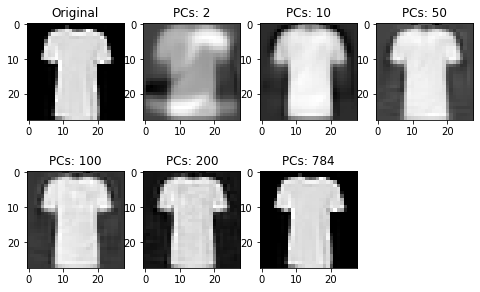

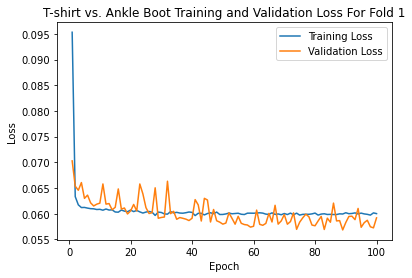

 10%|█         | 1/10 [00:04<00:40,  4.46s/it]

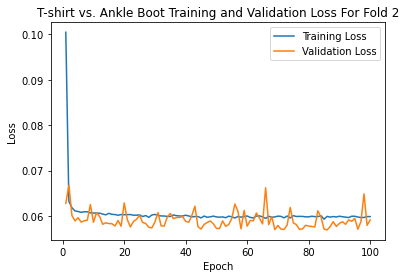

 20%|██        | 2/10 [00:08<00:34,  4.34s/it]

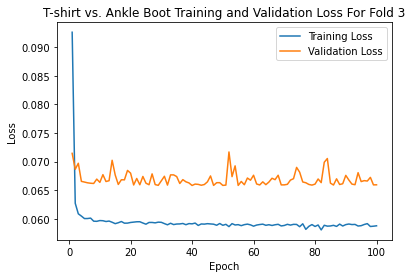

 30%|███       | 3/10 [00:12<00:29,  4.23s/it]

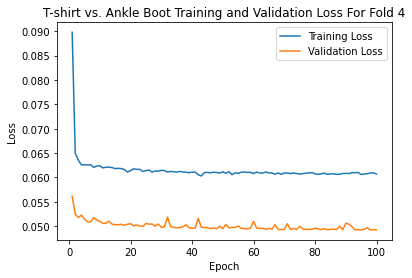

 40%|████      | 4/10 [00:16<00:24,  4.15s/it]

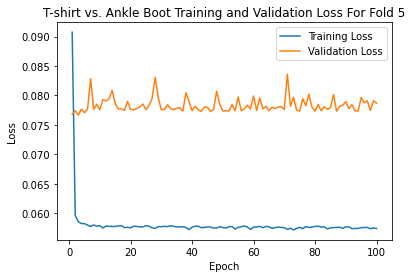

 50%|█████     | 5/10 [00:20<00:20,  4.09s/it]

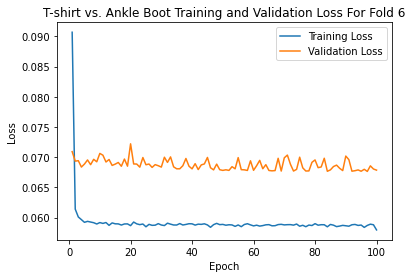

 60%|██████    | 6/10 [00:24<00:16,  4.04s/it]

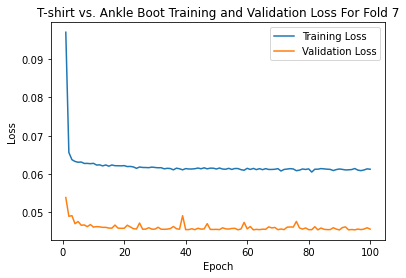

 70%|███████   | 7/10 [00:28<00:12,  4.04s/it]

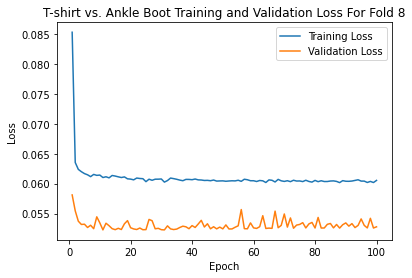

 80%|████████  | 8/10 [00:32<00:08,  4.02s/it]

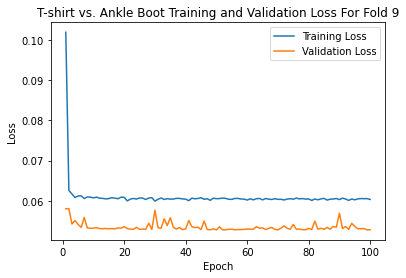

 90%|█████████ | 9/10 [00:36<00:03,  3.99s/it]

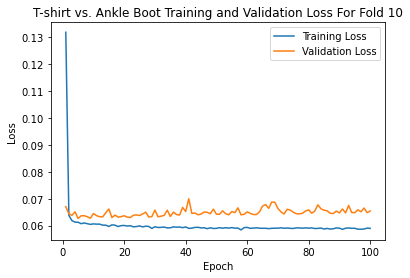

100%|██████████| 10/10 [00:40<00:00,  4.03s/it]


Average validation accuracy: 0.9791666666666666
PCS: 2
0.979 0, 9
(784, 2) k_pcs shape - 09


  0%|          | 0/10 [00:00<?, ?it/s]

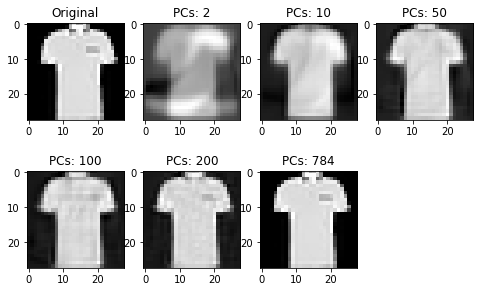

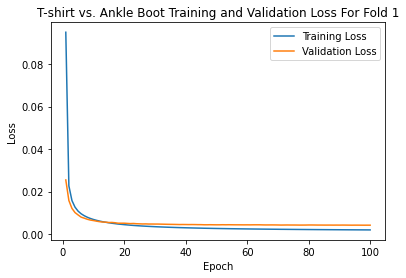

 10%|█         | 1/10 [00:04<00:39,  4.38s/it]

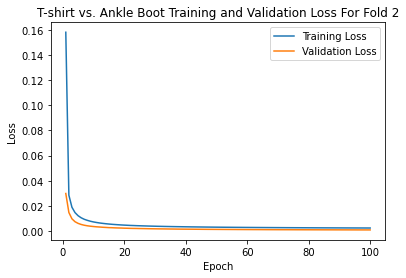

 20%|██        | 2/10 [00:08<00:34,  4.28s/it]

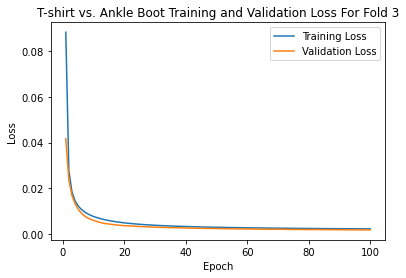

 30%|███       | 3/10 [00:12<00:29,  4.26s/it]

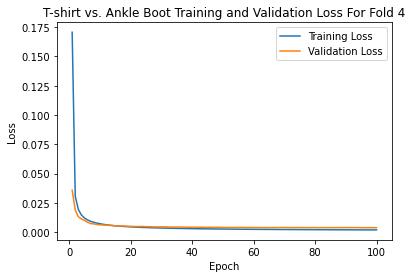

 40%|████      | 4/10 [00:16<00:25,  4.22s/it]

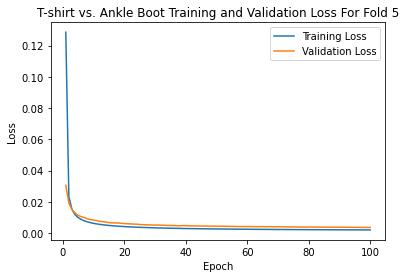

 50%|█████     | 5/10 [00:20<00:20,  4.19s/it]

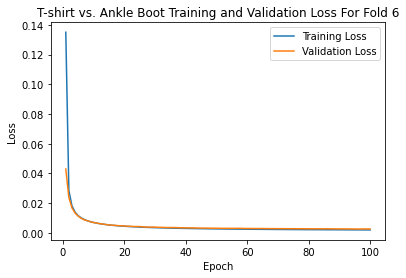

 60%|██████    | 6/10 [00:24<00:16,  4.16s/it]

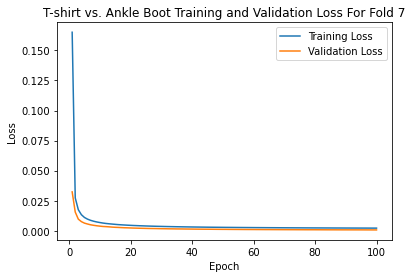

 70%|███████   | 7/10 [00:29<00:12,  4.14s/it]

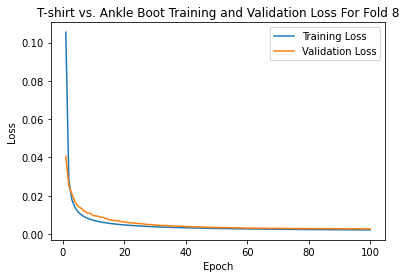

 80%|████████  | 8/10 [00:33<00:08,  4.13s/it]

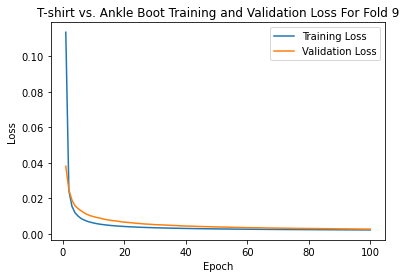

 90%|█████████ | 9/10 [00:37<00:04,  4.12s/it]

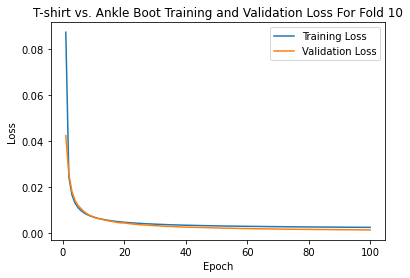

100%|██████████| 10/10 [00:41<00:00,  4.14s/it]


Average validation accuracy: 0.9995833333333334
PCS: 10
0.9995 0, 9
(784, 10) k_pcs shape - 09


  0%|          | 0/10 [00:00<?, ?it/s]

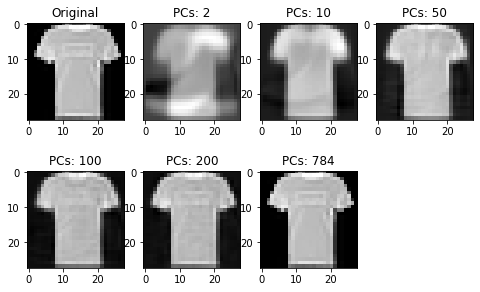

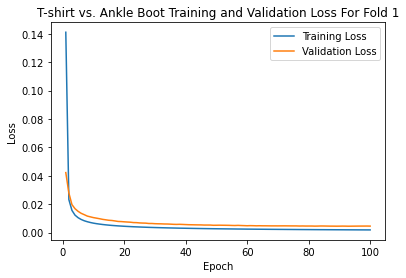

 10%|█         | 1/10 [00:04<00:44,  4.97s/it]

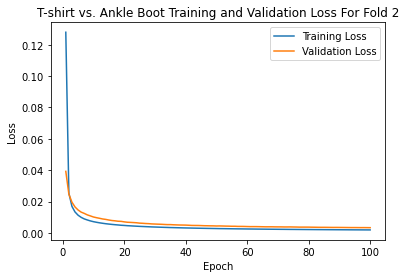

 20%|██        | 2/10 [00:09<00:38,  4.85s/it]

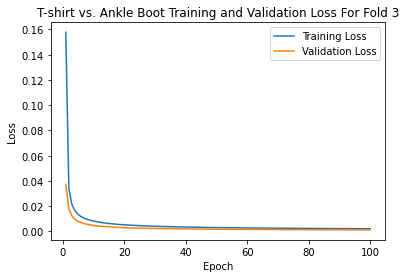

 30%|███       | 3/10 [00:14<00:33,  4.77s/it]

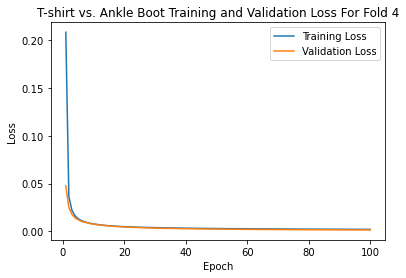

 40%|████      | 4/10 [00:18<00:28,  4.68s/it]

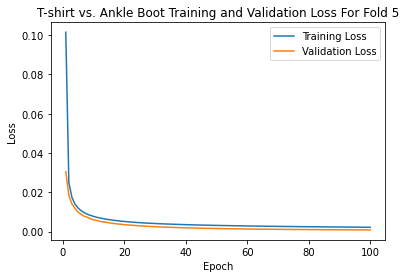

 50%|█████     | 5/10 [00:23<00:23,  4.62s/it]

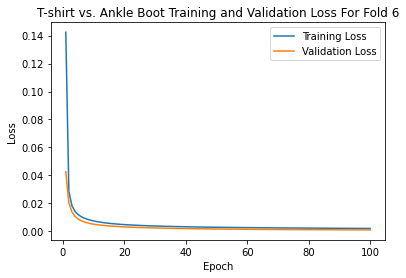

 60%|██████    | 6/10 [00:27<00:18,  4.58s/it]

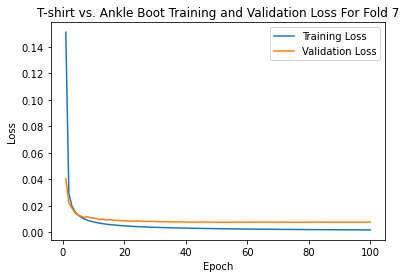

 70%|███████   | 7/10 [00:32<00:13,  4.57s/it]

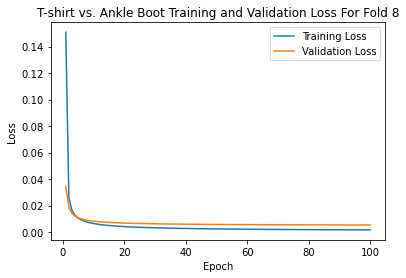

 80%|████████  | 8/10 [00:36<00:09,  4.53s/it]

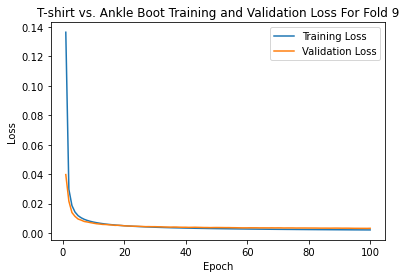

 90%|█████████ | 9/10 [00:40<00:04,  4.50s/it]

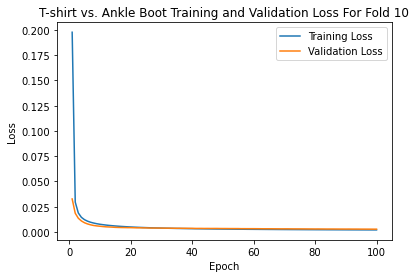

100%|██████████| 10/10 [00:45<00:00,  4.54s/it]


Average validation accuracy: 0.9992500000000002
PCS: 50
0.9995 0, 9
(784, 50) k_pcs shape - 09


  0%|          | 0/10 [00:00<?, ?it/s]

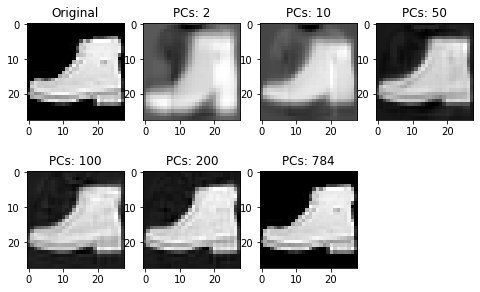

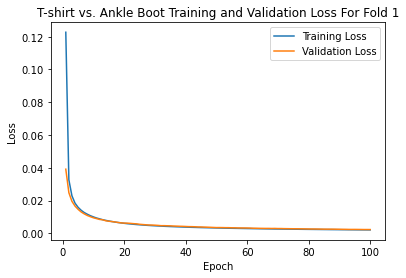

 10%|█         | 1/10 [00:05<00:48,  5.33s/it]

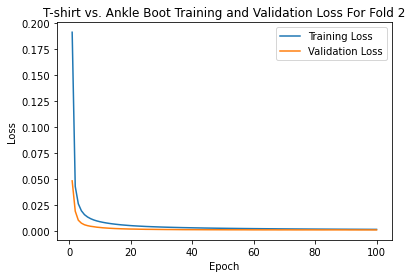

 20%|██        | 2/10 [00:10<00:41,  5.24s/it]

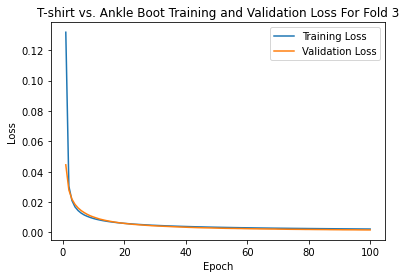

 30%|███       | 3/10 [00:15<00:36,  5.16s/it]

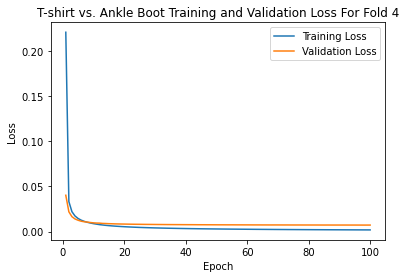

 40%|████      | 4/10 [00:20<00:30,  5.11s/it]

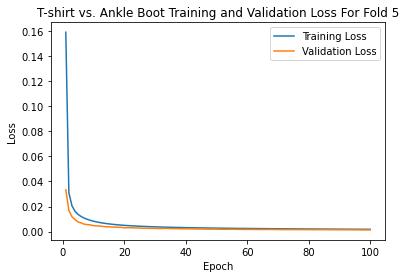

 50%|█████     | 5/10 [00:25<00:25,  5.06s/it]

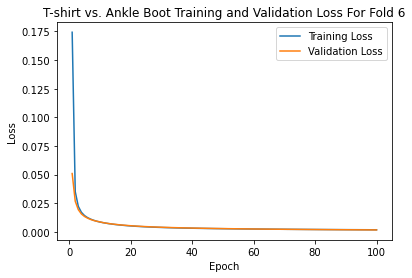

 60%|██████    | 6/10 [00:30<00:20,  5.02s/it]

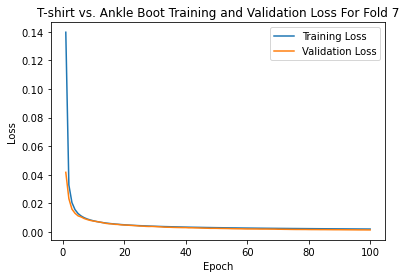

 70%|███████   | 7/10 [00:35<00:14,  4.99s/it]

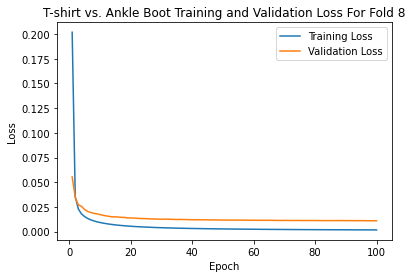

 80%|████████  | 8/10 [00:40<00:09,  4.96s/it]

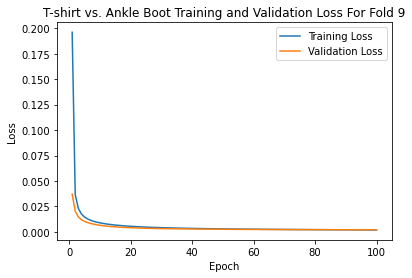

 90%|█████████ | 9/10 [00:45<00:04,  4.99s/it]

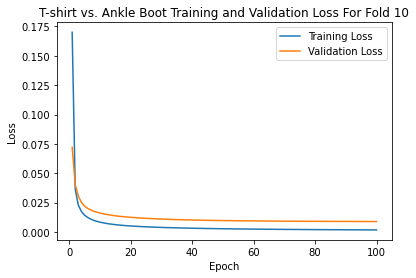

100%|██████████| 10/10 [00:50<00:00,  5.01s/it]


Average validation accuracy: 0.9995
PCS: 100
0.999 0, 9
(784, 100) k_pcs shape - 09


  0%|          | 0/10 [00:00<?, ?it/s]

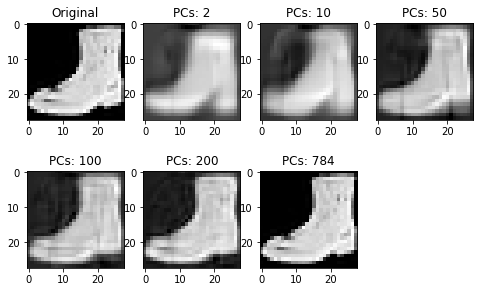

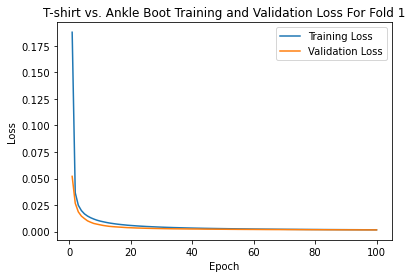

 10%|█         | 1/10 [00:06<00:56,  6.25s/it]

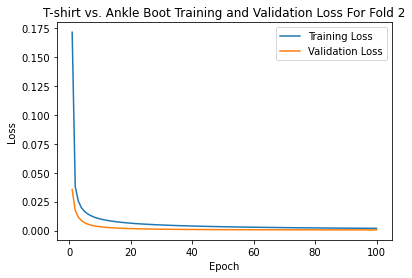

 20%|██        | 2/10 [00:12<00:49,  6.15s/it]

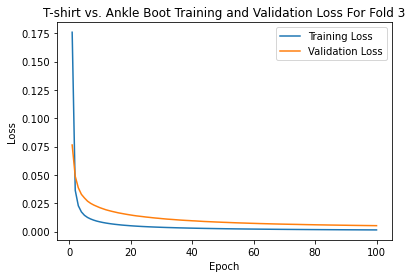

 30%|███       | 3/10 [00:18<00:42,  6.08s/it]

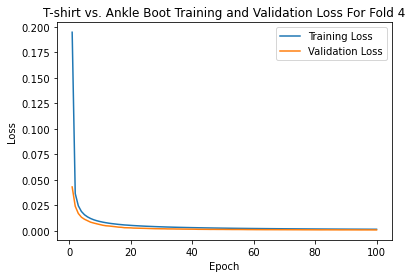

 40%|████      | 4/10 [00:23<00:36,  6.03s/it]

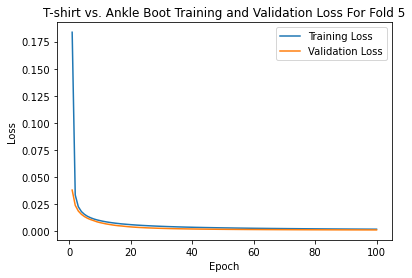

 50%|█████     | 5/10 [00:29<00:29,  5.97s/it]

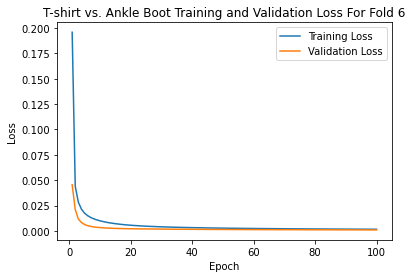

 60%|██████    | 6/10 [00:35<00:23,  5.94s/it]

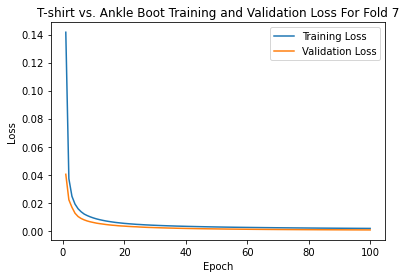

 70%|███████   | 7/10 [00:41<00:17,  5.94s/it]

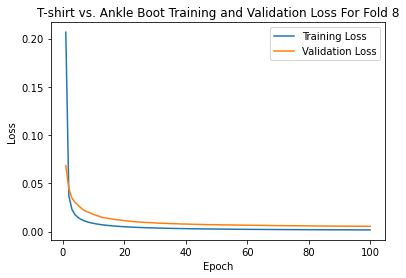

 80%|████████  | 8/10 [00:47<00:11,  5.96s/it]

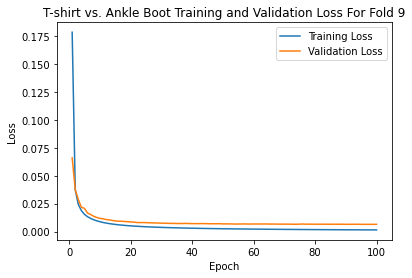

 90%|█████████ | 9/10 [00:53<00:06,  6.07s/it]

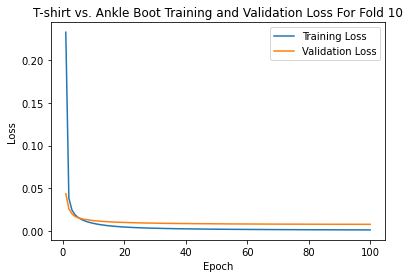

100%|██████████| 10/10 [00:59<00:00,  5.99s/it]


Average validation accuracy: 0.9996666666666666
PCS: 200
0.999 0, 9
(784, 200) k_pcs shape - 09


  0%|          | 0/10 [00:00<?, ?it/s]

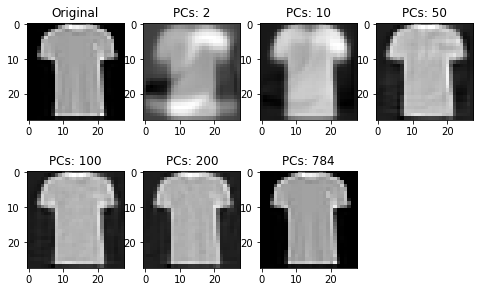

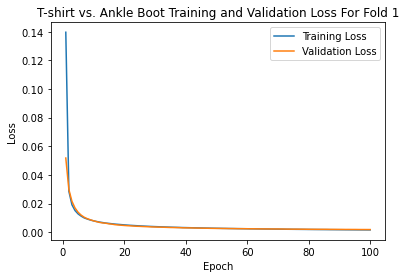

 10%|█         | 1/10 [00:08<01:12,  8.05s/it]

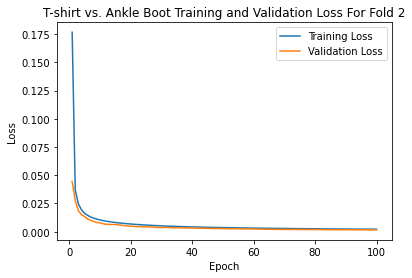

 20%|██        | 2/10 [00:15<01:02,  7.87s/it]

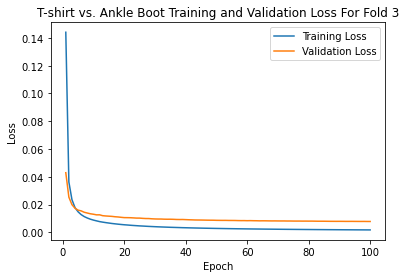

 30%|███       | 3/10 [00:23<00:54,  7.76s/it]

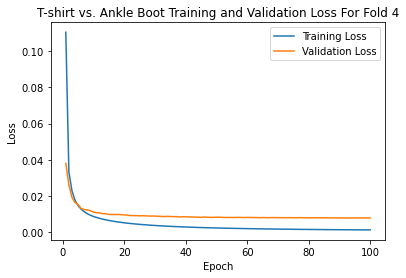

 40%|████      | 4/10 [00:30<00:45,  7.64s/it]

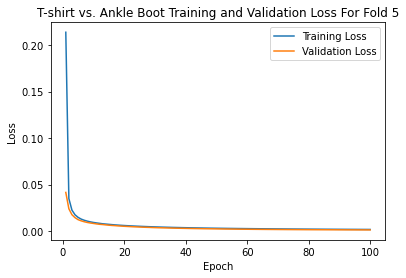

 50%|█████     | 5/10 [00:37<00:37,  7.55s/it]

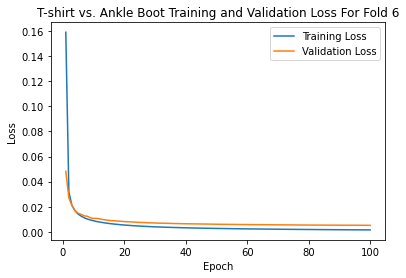

 60%|██████    | 6/10 [00:45<00:30,  7.54s/it]

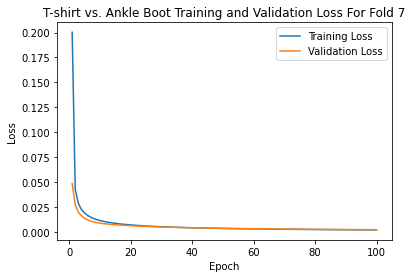

 70%|███████   | 7/10 [00:52<00:22,  7.50s/it]

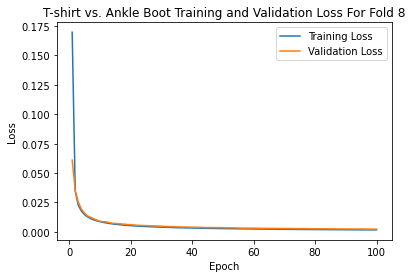

 80%|████████  | 8/10 [00:59<00:14,  7.44s/it]

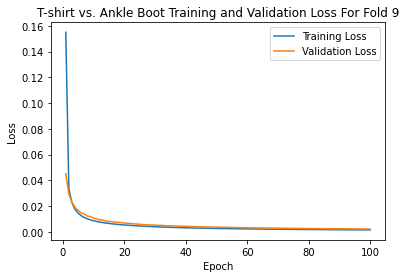

 90%|█████████ | 9/10 [01:07<00:07,  7.42s/it]

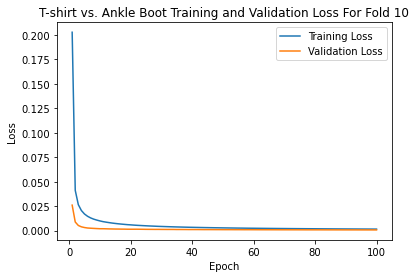

100%|██████████| 10/10 [01:14<00:00,  7.47s/it]


Average validation accuracy: 0.9995
PCS: 350
0.9985 0, 9
(784, 350) k_pcs shape - 09


  0%|          | 0/10 [00:00<?, ?it/s]

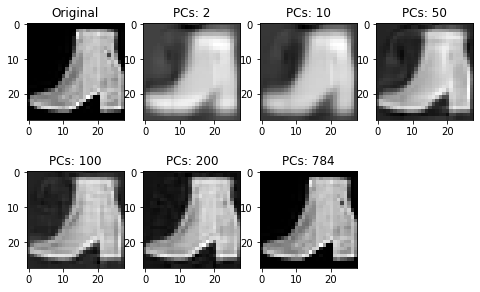

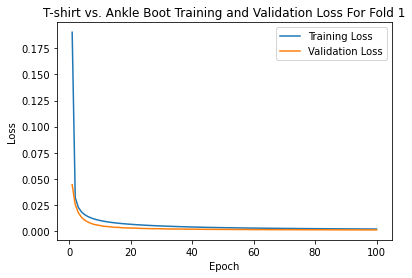

 10%|█         | 1/10 [00:11<01:45, 11.67s/it]

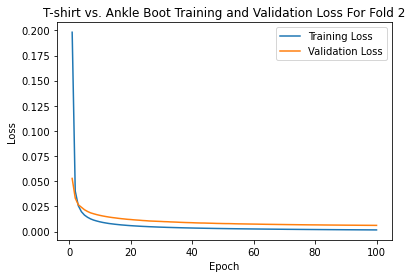

 20%|██        | 2/10 [00:22<01:32, 11.55s/it]

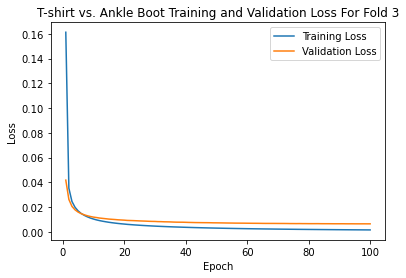

 30%|███       | 3/10 [00:34<01:20, 11.45s/it]

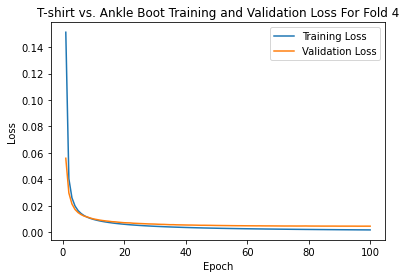

 40%|████      | 4/10 [00:45<01:08, 11.38s/it]

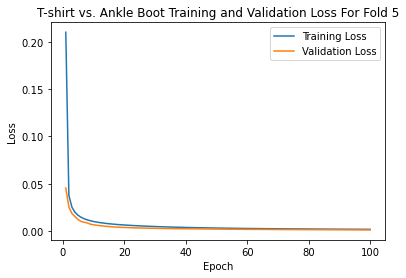

 50%|█████     | 5/10 [00:56<00:56, 11.31s/it]

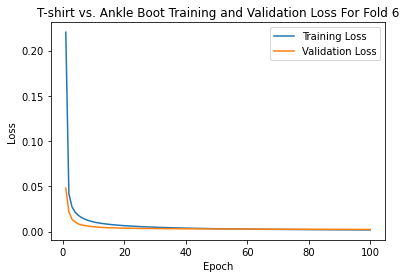

 60%|██████    | 6/10 [01:07<00:45, 11.31s/it]

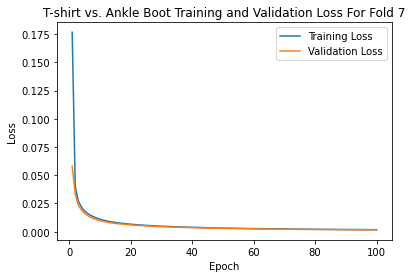

 70%|███████   | 7/10 [01:19<00:34, 11.36s/it]

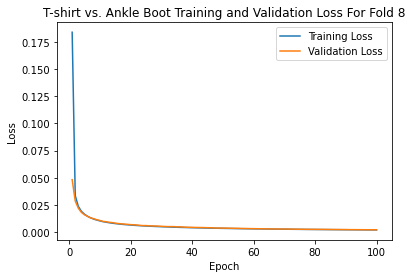

 80%|████████  | 8/10 [01:30<00:22, 11.31s/it]

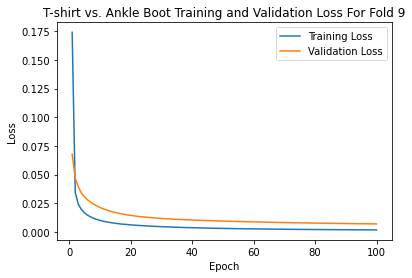

 90%|█████████ | 9/10 [01:41<00:11, 11.28s/it]

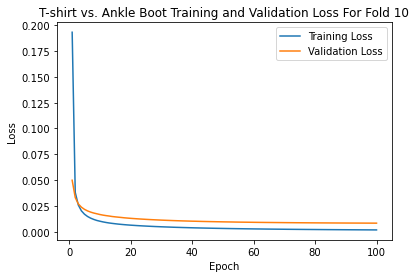

100%|██████████| 10/10 [01:52<00:00, 11.29s/it]


Average validation accuracy: 0.9996666666666666
PCS: 784
0.998 0, 9
(784, 784) k_pcs shape - 09


  0%|          | 0/10 [00:00<?, ?it/s]

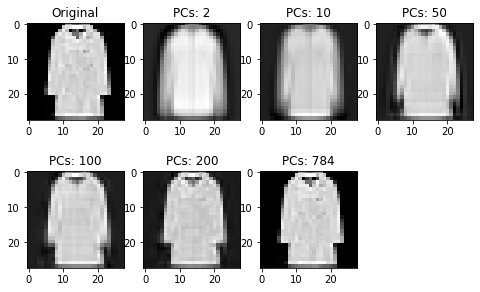

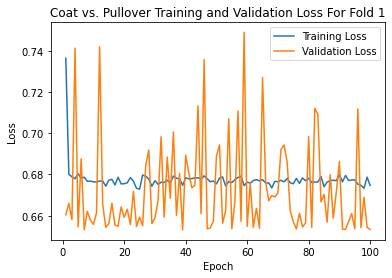

 10%|█         | 1/10 [00:04<00:39,  4.33s/it]

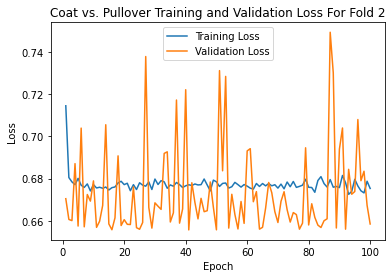

 20%|██        | 2/10 [00:08<00:34,  4.26s/it]

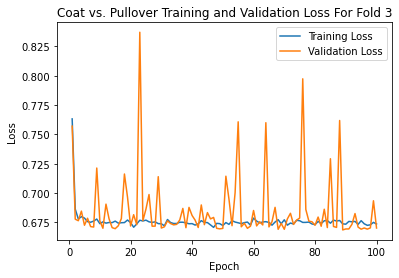

 30%|███       | 3/10 [00:12<00:29,  4.18s/it]

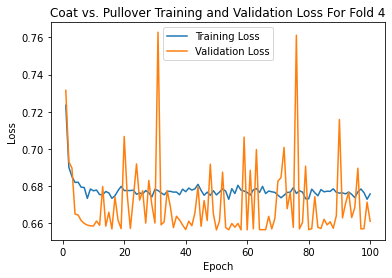

 40%|████      | 4/10 [00:16<00:24,  4.14s/it]

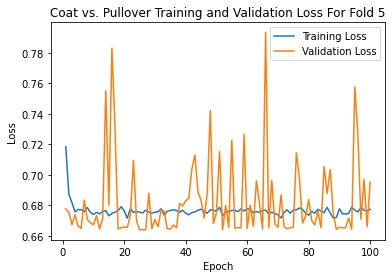

 50%|█████     | 5/10 [00:20<00:20,  4.12s/it]

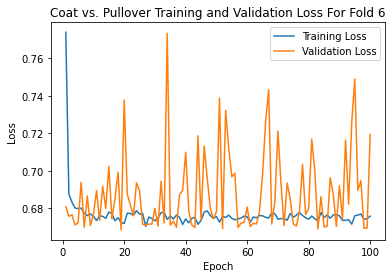

 60%|██████    | 6/10 [00:24<00:16,  4.07s/it]

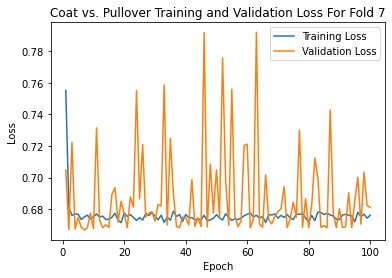

 70%|███████   | 7/10 [00:28<00:12,  4.06s/it]

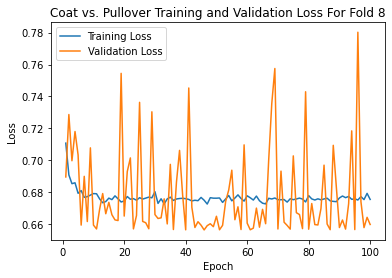

 80%|████████  | 8/10 [00:32<00:08,  4.04s/it]

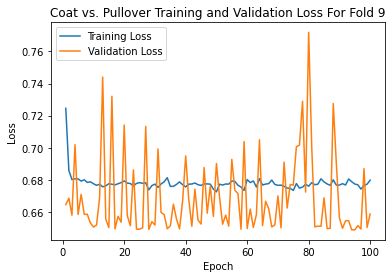

 90%|█████████ | 9/10 [00:36<00:04,  4.06s/it]

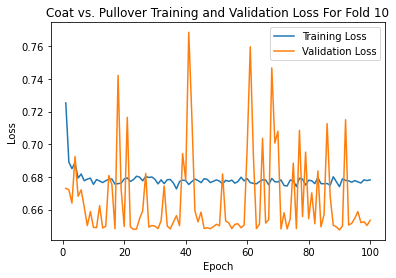

100%|██████████| 10/10 [00:40<00:00,  4.07s/it]


Average validation accuracy: 0.58725
PCS: 2
0.565 2, 4
(784, 2) k_pcs shape - 24


  0%|          | 0/10 [00:00<?, ?it/s]

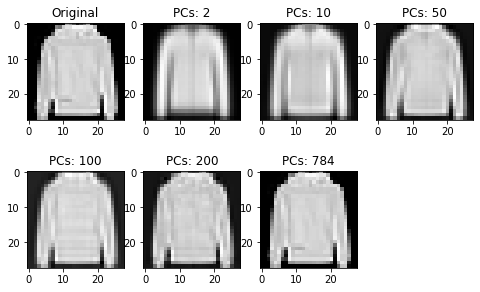

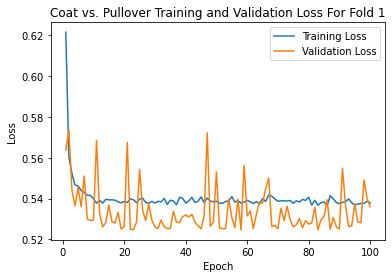

 10%|█         | 1/10 [00:04<00:40,  4.49s/it]

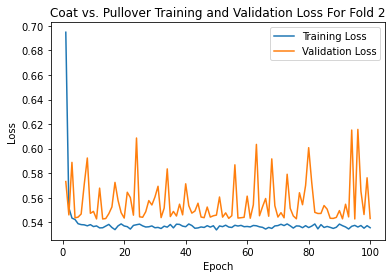

 20%|██        | 2/10 [00:08<00:34,  4.37s/it]

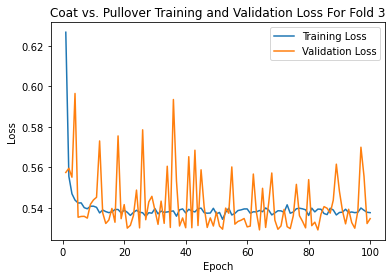

 30%|███       | 3/10 [00:12<00:29,  4.28s/it]

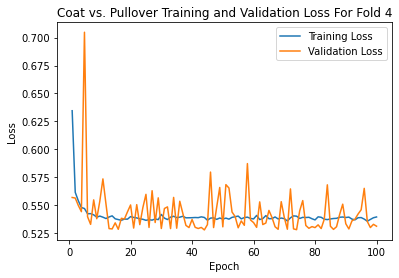

 40%|████      | 4/10 [00:16<00:25,  4.23s/it]

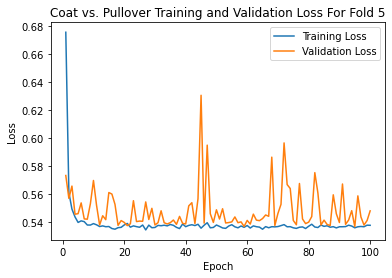

 50%|█████     | 5/10 [00:20<00:20,  4.20s/it]

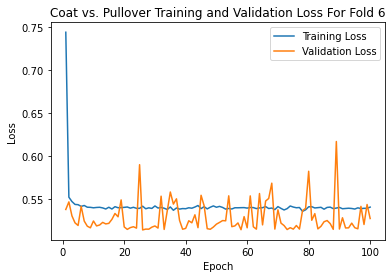

 60%|██████    | 6/10 [00:25<00:16,  4.18s/it]

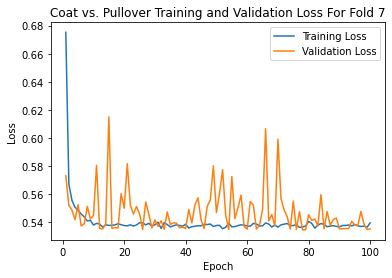

 70%|███████   | 7/10 [00:29<00:12,  4.20s/it]

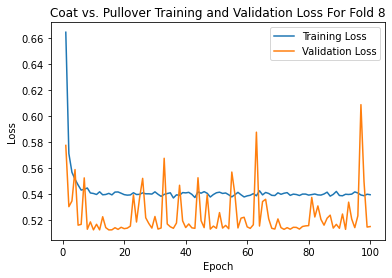

 80%|████████  | 8/10 [00:33<00:08,  4.20s/it]

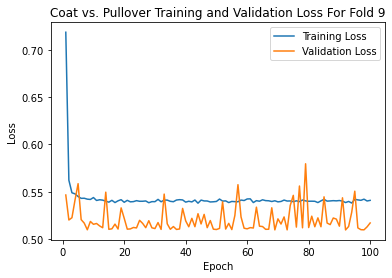

 90%|█████████ | 9/10 [00:37<00:04,  4.20s/it]

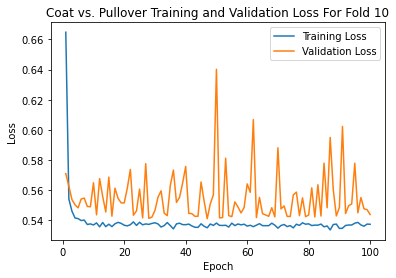

100%|██████████| 10/10 [00:41<00:00,  4.18s/it]


Average validation accuracy: 0.7420833333333332
PCS: 10
0.7295 2, 4
(784, 10) k_pcs shape - 24


  0%|          | 0/10 [00:00<?, ?it/s]

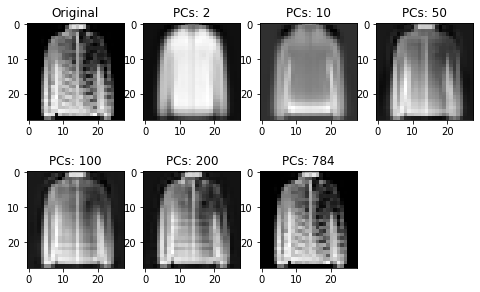

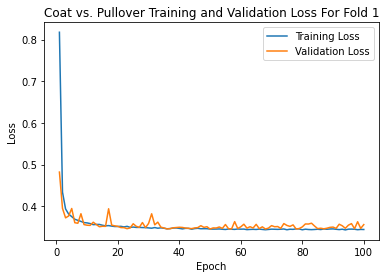

 10%|█         | 1/10 [00:04<00:44,  4.94s/it]

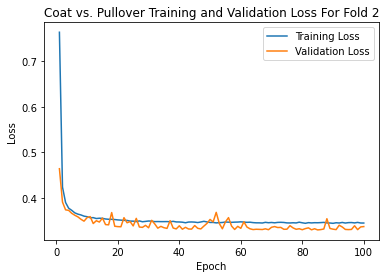

 20%|██        | 2/10 [00:09<00:38,  4.85s/it]

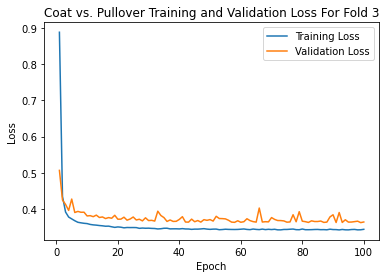

 30%|███       | 3/10 [00:14<00:33,  4.75s/it]

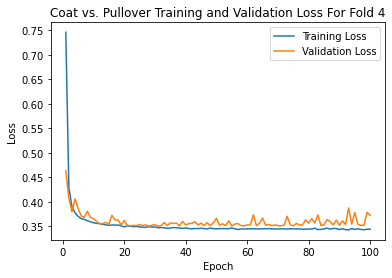

 40%|████      | 4/10 [00:18<00:28,  4.68s/it]

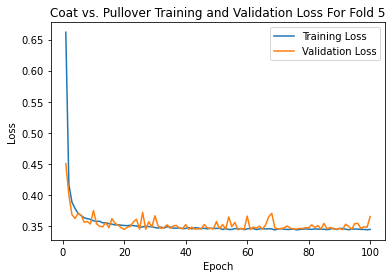

 50%|█████     | 5/10 [00:23<00:23,  4.63s/it]

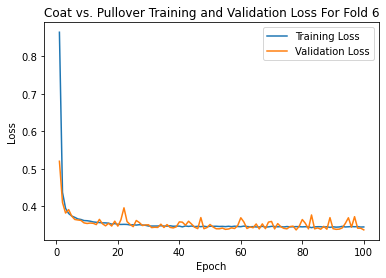

 60%|██████    | 6/10 [00:27<00:18,  4.65s/it]

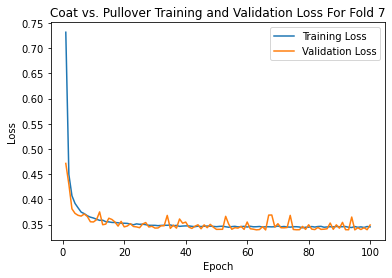

 70%|███████   | 7/10 [00:32<00:13,  4.62s/it]

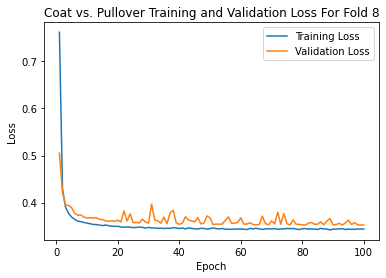

 80%|████████  | 8/10 [00:36<00:09,  4.60s/it]

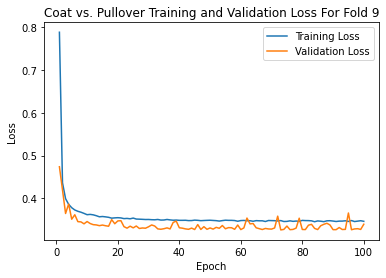

 90%|█████████ | 9/10 [00:41<00:04,  4.59s/it]

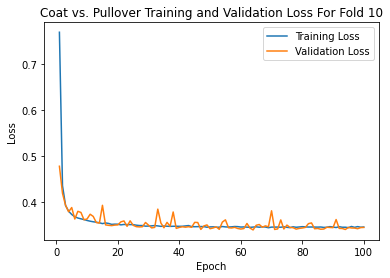

100%|██████████| 10/10 [00:46<00:00,  4.62s/it]


Average validation accuracy: 0.8567499999999999
PCS: 50
0.836 2, 4
(784, 50) k_pcs shape - 24


  0%|          | 0/10 [00:00<?, ?it/s]

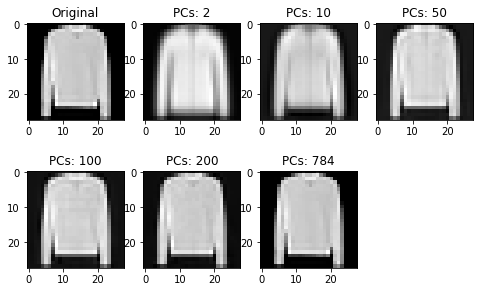

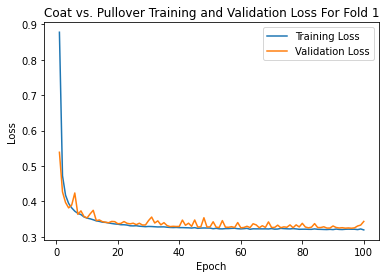

 10%|█         | 1/10 [00:05<00:48,  5.39s/it]

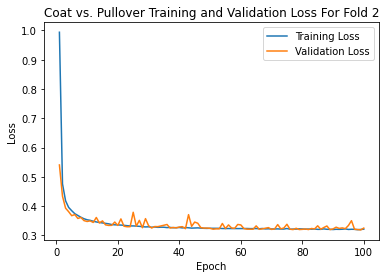

 20%|██        | 2/10 [00:10<00:42,  5.30s/it]

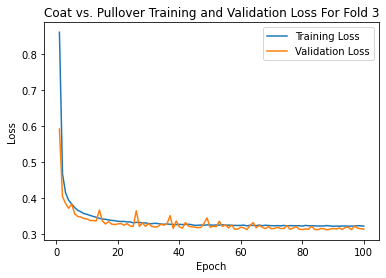

 30%|███       | 3/10 [00:15<00:36,  5.23s/it]

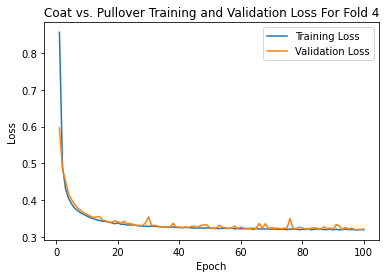

 40%|████      | 4/10 [00:20<00:31,  5.19s/it]

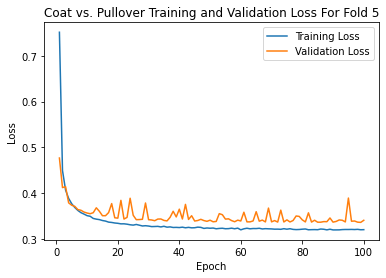

 50%|█████     | 5/10 [00:25<00:25,  5.14s/it]

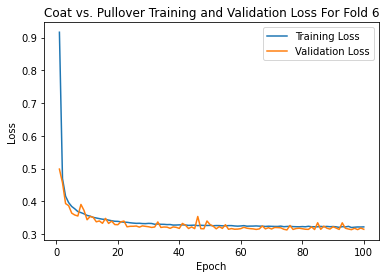

 60%|██████    | 6/10 [00:30<00:20,  5.13s/it]

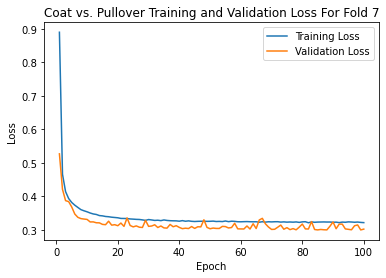

 70%|███████   | 7/10 [00:35<00:15,  5.11s/it]

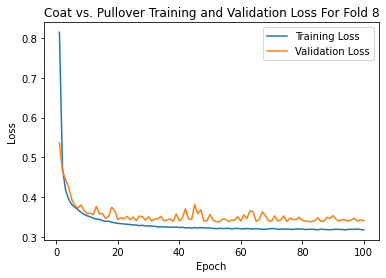

 80%|████████  | 8/10 [00:40<00:10,  5.11s/it]

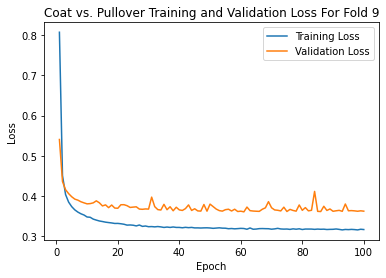

 90%|█████████ | 9/10 [00:46<00:05,  5.09s/it]

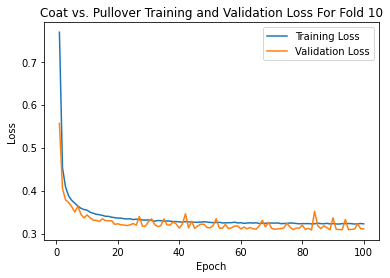

100%|██████████| 10/10 [00:51<00:00,  5.11s/it]


Average validation accuracy: 0.8718333333333333
PCS: 100
0.8505 2, 4
(784, 100) k_pcs shape - 24


  0%|          | 0/10 [00:00<?, ?it/s]

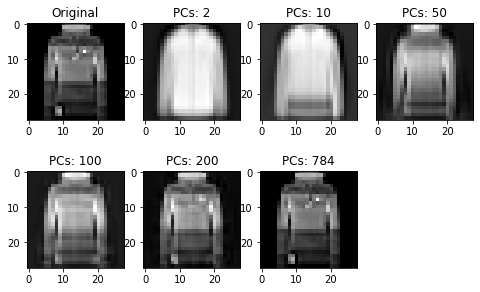

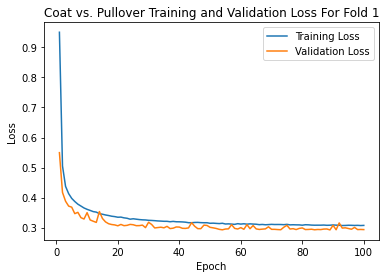

 10%|█         | 1/10 [00:06<00:57,  6.37s/it]

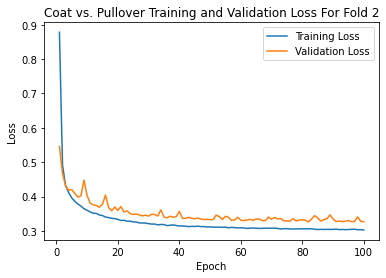

 20%|██        | 2/10 [00:12<00:50,  6.26s/it]

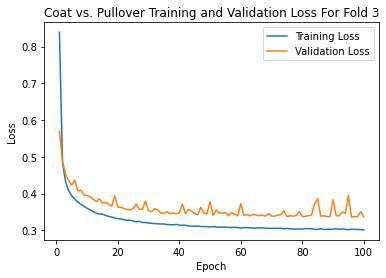

 30%|███       | 3/10 [00:18<00:43,  6.21s/it]

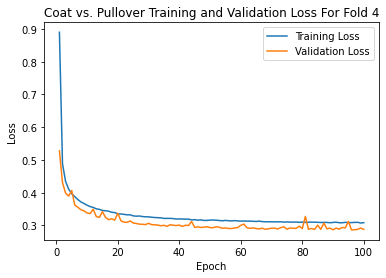

 40%|████      | 4/10 [00:24<00:37,  6.20s/it]

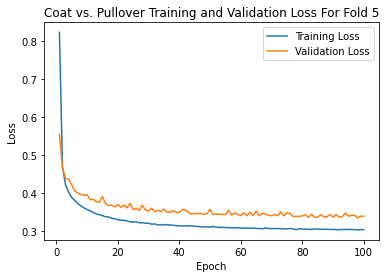

 50%|█████     | 5/10 [00:30<00:30,  6.17s/it]

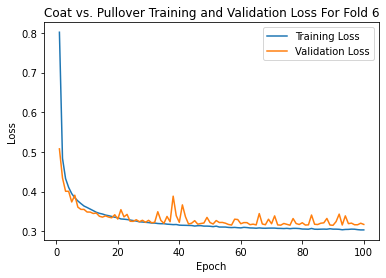

 60%|██████    | 6/10 [00:36<00:24,  6.12s/it]

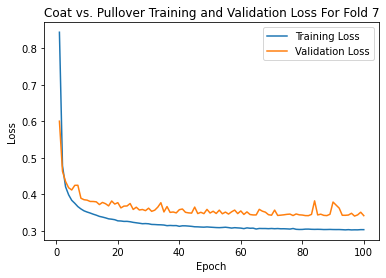

 70%|███████   | 7/10 [00:42<00:18,  6.09s/it]

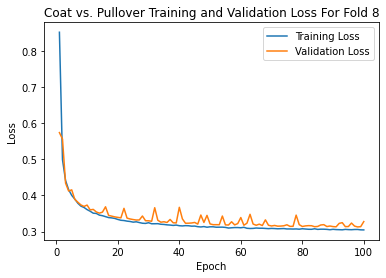

 80%|████████  | 8/10 [00:48<00:12,  6.07s/it]

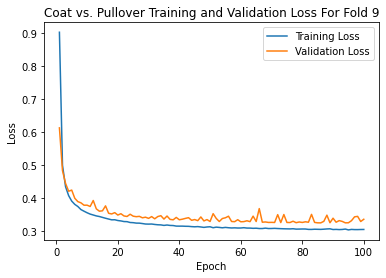

 90%|█████████ | 9/10 [00:54<00:06,  6.04s/it]

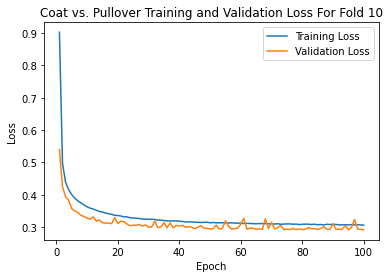

100%|██████████| 10/10 [01:00<00:00,  6.07s/it]


Average validation accuracy: 0.8785833333333333
PCS: 200
0.8495 2, 4
(784, 200) k_pcs shape - 24


  0%|          | 0/10 [00:00<?, ?it/s]

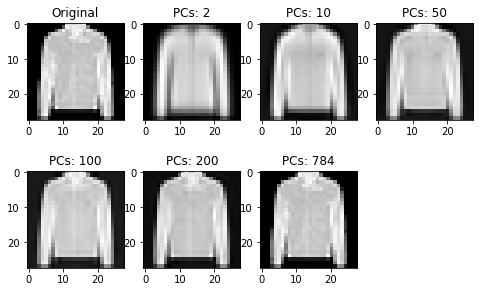

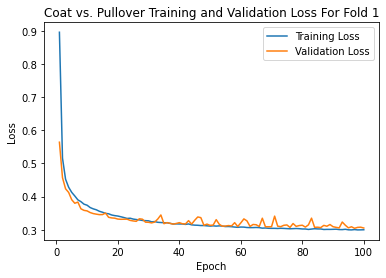

 10%|█         | 1/10 [00:07<01:09,  7.71s/it]

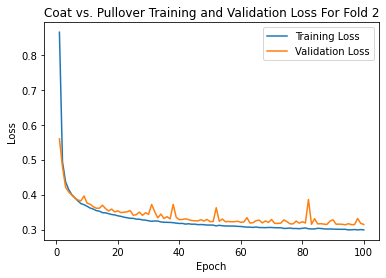

 20%|██        | 2/10 [00:15<01:00,  7.59s/it]

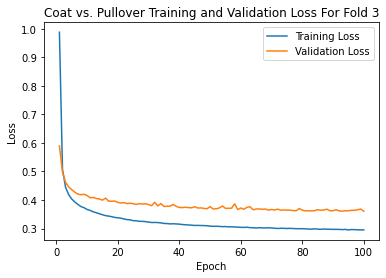

 30%|███       | 3/10 [00:22<00:52,  7.56s/it]

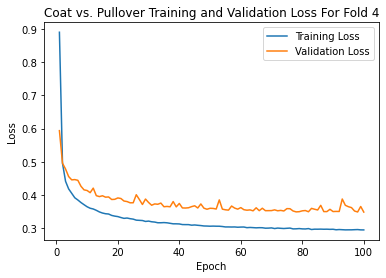

 40%|████      | 4/10 [00:29<00:45,  7.51s/it]

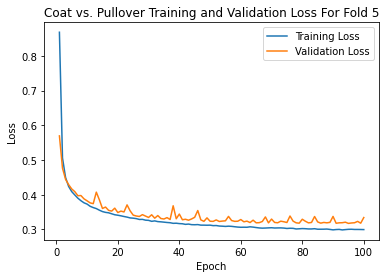

 50%|█████     | 5/10 [00:37<00:37,  7.48s/it]

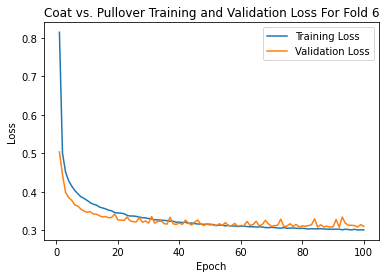

 60%|██████    | 6/10 [00:44<00:29,  7.48s/it]

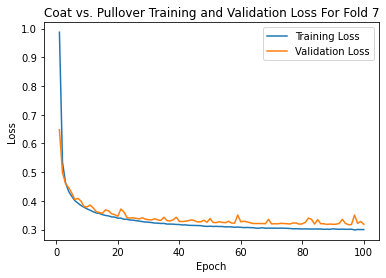

 70%|███████   | 7/10 [00:51<00:22,  7.38s/it]

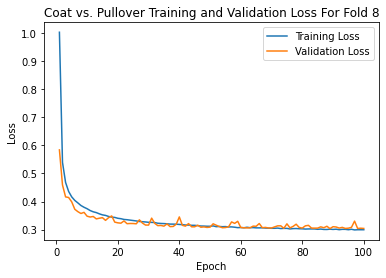

 80%|████████  | 8/10 [00:59<00:14,  7.31s/it]

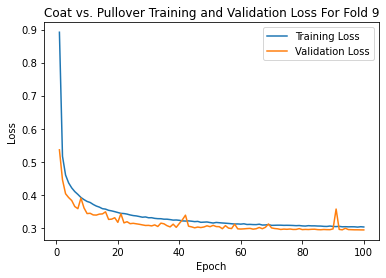

 90%|█████████ | 9/10 [01:06<00:07,  7.24s/it]

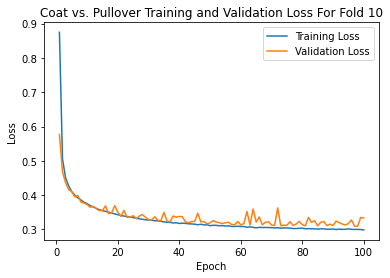

100%|██████████| 10/10 [01:13<00:00,  7.32s/it]


Average validation accuracy: 0.8798333333333334
PCS: 350
0.853 2, 4
(784, 350) k_pcs shape - 24


  0%|          | 0/10 [00:00<?, ?it/s]

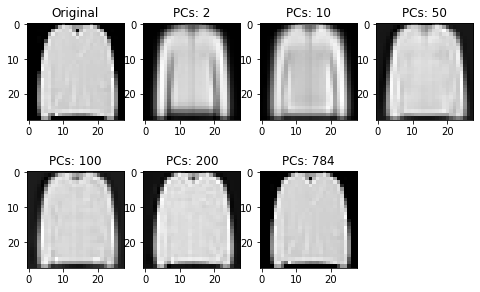

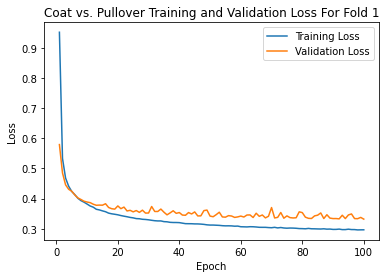

 10%|█         | 1/10 [00:11<01:41, 11.24s/it]

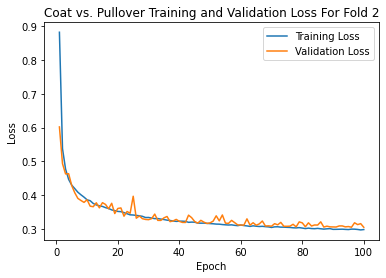

 20%|██        | 2/10 [00:22<01:28, 11.12s/it]

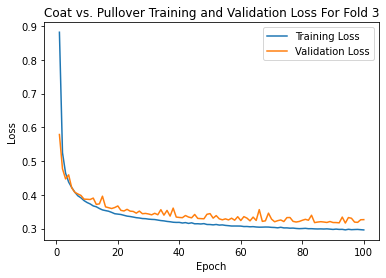

 30%|███       | 3/10 [00:32<01:17, 11.04s/it]

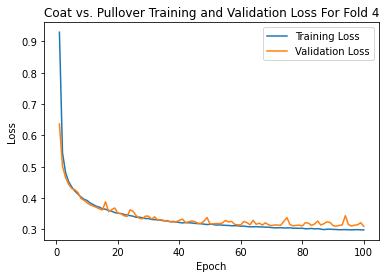

 40%|████      | 4/10 [00:43<01:05, 10.98s/it]

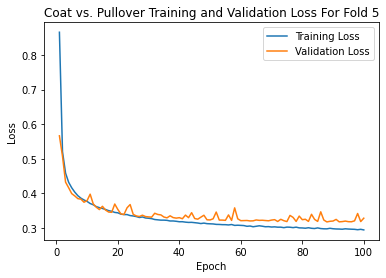

 50%|█████     | 5/10 [00:54<00:54, 10.95s/it]

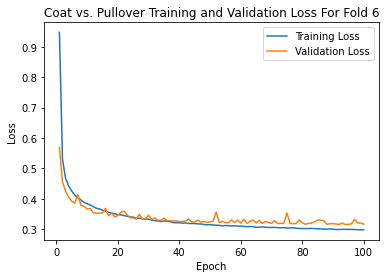

 60%|██████    | 6/10 [01:05<00:43, 10.91s/it]

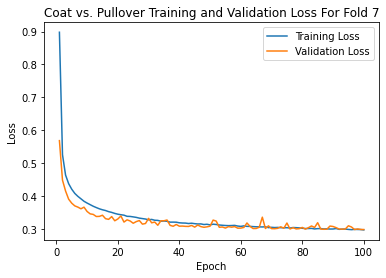

 70%|███████   | 7/10 [01:16<00:32, 10.89s/it]

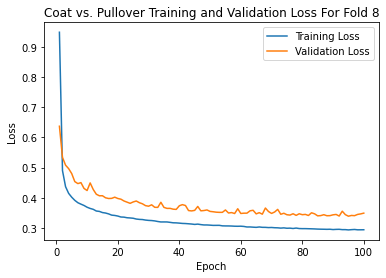

 80%|████████  | 8/10 [01:27<00:21, 10.91s/it]

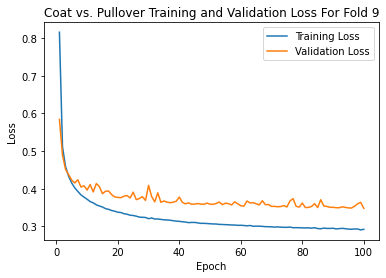

 90%|█████████ | 9/10 [01:38<00:10, 10.86s/it]

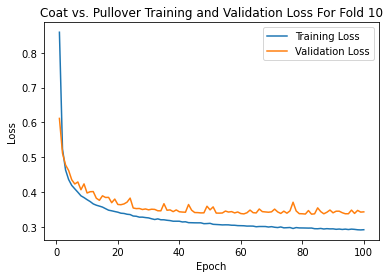

100%|██████████| 10/10 [01:48<00:00, 10.88s/it]


Average validation accuracy: 0.8781666666666667
PCS: 784
0.8545 2, 4
(784, 784) k_pcs shape - 24


  0%|          | 0/10 [00:00<?, ?it/s]

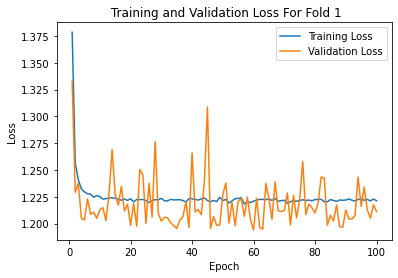

 10%|█         | 1/10 [00:13<02:05, 13.97s/it]

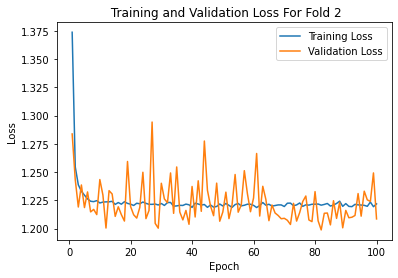

 20%|██        | 2/10 [00:27<01:51, 13.90s/it]

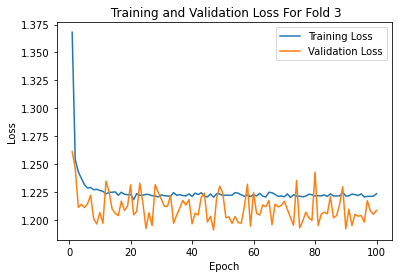

 30%|███       | 3/10 [00:41<01:36, 13.81s/it]

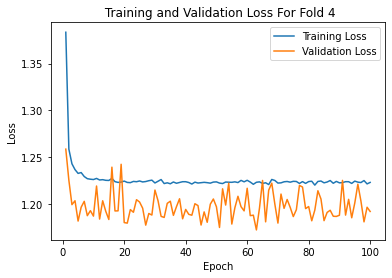

 40%|████      | 4/10 [00:55<01:23, 13.86s/it]

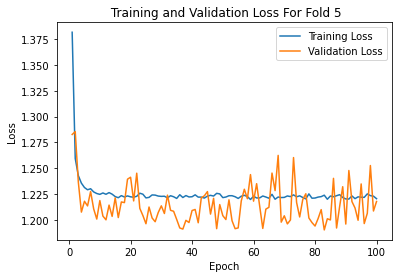

 50%|█████     | 5/10 [01:09<01:09, 13.85s/it]

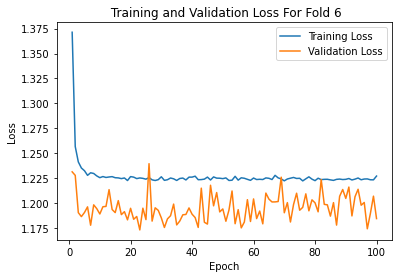

 60%|██████    | 6/10 [01:22<00:55, 13.79s/it]

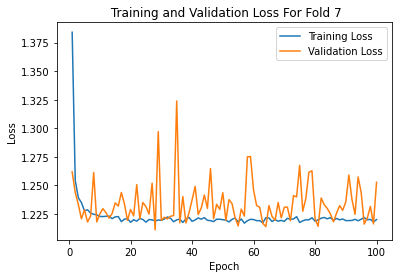

 70%|███████   | 7/10 [01:36<00:41, 13.79s/it]

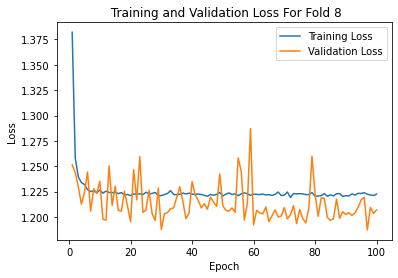

 80%|████████  | 8/10 [01:50<00:27, 13.83s/it]

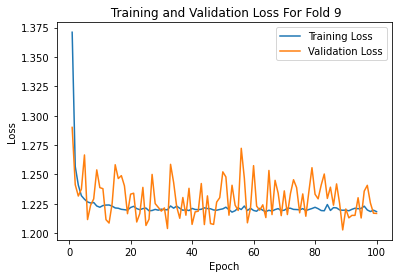

 90%|█████████ | 9/10 [02:04<00:13, 13.84s/it]

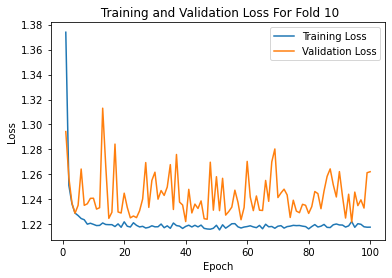

100%|██████████| 10/10 [02:18<00:00, 13.82s/it]


Average validation accuracy: 0.5059333333333333
PCS: 2
0.5096 all
(784, 2) k_pcs shape - all


  0%|          | 0/10 [00:00<?, ?it/s]

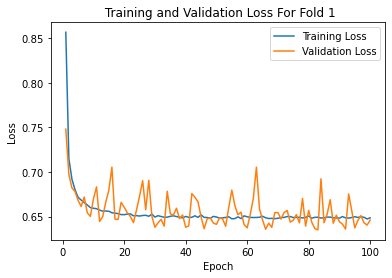

 10%|█         | 1/10 [00:15<02:23, 15.94s/it]

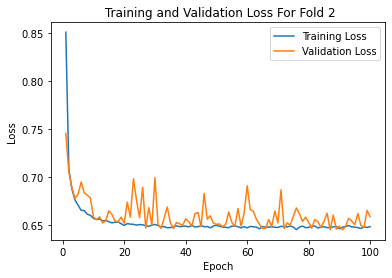

 20%|██        | 2/10 [00:31<02:07, 15.93s/it]

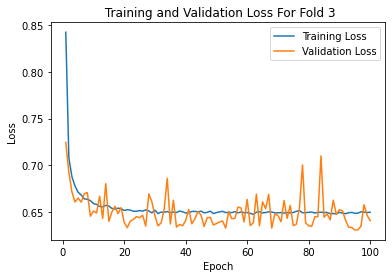

 30%|███       | 3/10 [00:47<01:50, 15.77s/it]

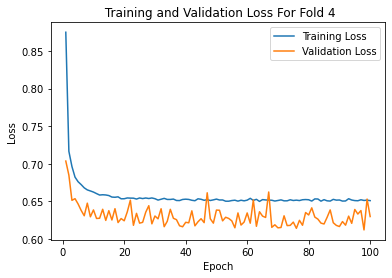

 40%|████      | 4/10 [01:03<01:34, 15.77s/it]

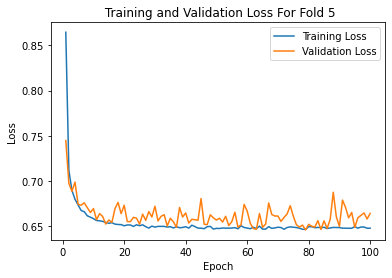

 50%|█████     | 5/10 [01:18<01:18, 15.69s/it]

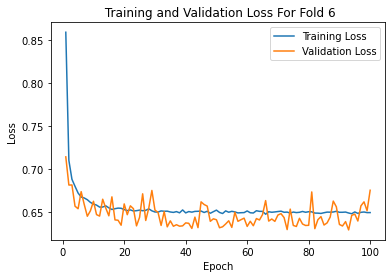

 60%|██████    | 6/10 [01:34<01:02, 15.74s/it]

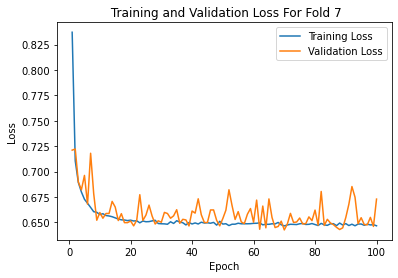

 70%|███████   | 7/10 [01:50<00:47, 15.78s/it]

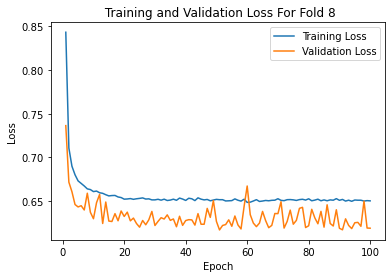

 80%|████████  | 8/10 [02:06<00:31, 15.82s/it]

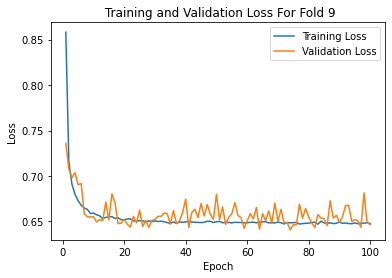

 90%|█████████ | 9/10 [02:22<00:15, 15.86s/it]

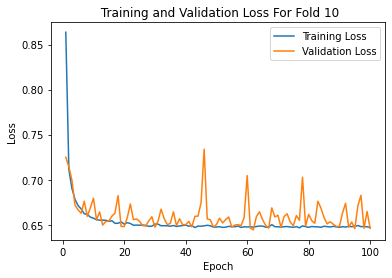

100%|██████████| 10/10 [02:37<00:00, 15.78s/it]


Average validation accuracy: 0.7667666666666667
PCS: 10
0.7559 all
(784, 10) k_pcs shape - all


  0%|          | 0/10 [00:00<?, ?it/s]

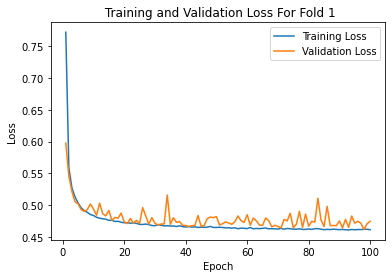

 10%|█         | 1/10 [00:22<03:24, 22.75s/it]

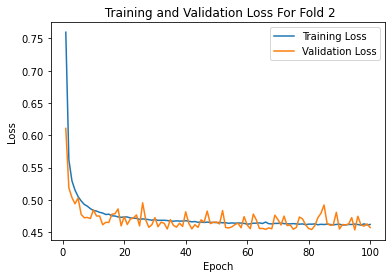

 20%|██        | 2/10 [00:45<03:01, 22.65s/it]

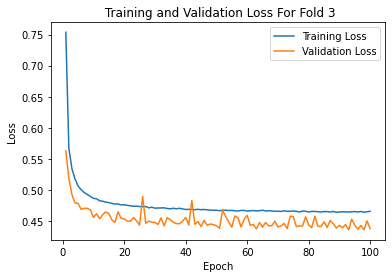

 30%|███       | 3/10 [01:07<02:38, 22.64s/it]

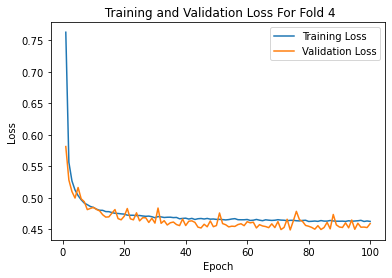

 40%|████      | 4/10 [01:30<02:15, 22.62s/it]

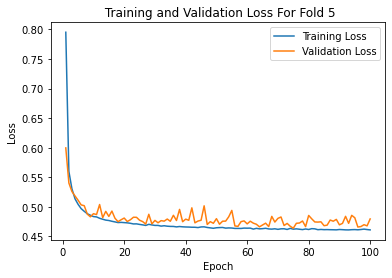

 50%|█████     | 5/10 [01:52<01:52, 22.57s/it]

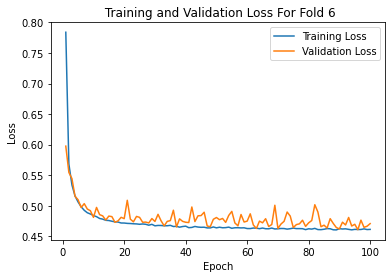

 60%|██████    | 6/10 [02:15<01:29, 22.50s/it]

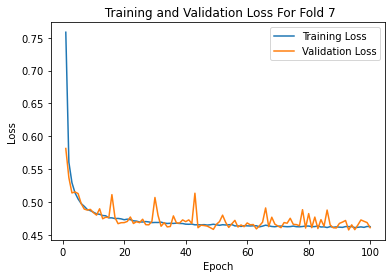

 70%|███████   | 7/10 [02:37<01:07, 22.49s/it]

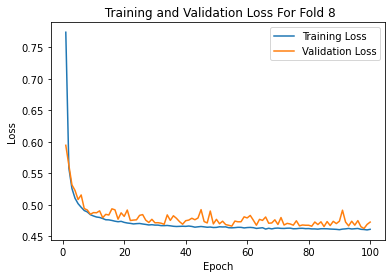

 80%|████████  | 8/10 [03:00<00:44, 22.49s/it]

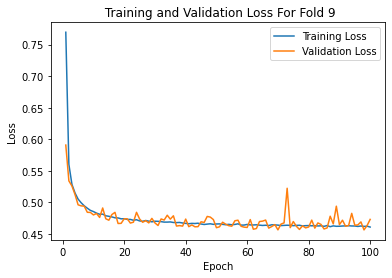

 90%|█████████ | 9/10 [03:22<00:22, 22.45s/it]

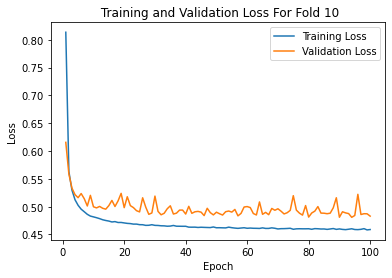

100%|██████████| 10/10 [03:44<00:00, 22.50s/it]


Average validation accuracy: 0.8419166666666668
PCS: 50
0.8261 all
(784, 50) k_pcs shape - all


  0%|          | 0/10 [00:00<?, ?it/s]

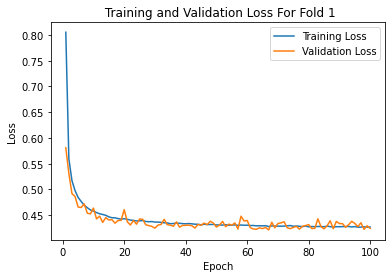

 10%|█         | 1/10 [00:32<04:49, 32.12s/it]

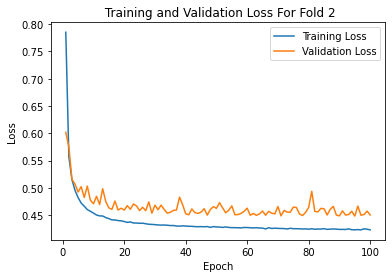

 20%|██        | 2/10 [01:04<04:16, 32.05s/it]

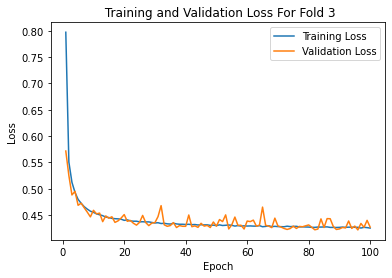

 30%|███       | 3/10 [01:36<03:44, 32.12s/it]

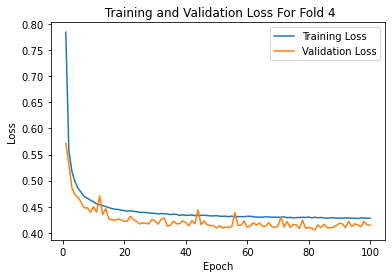

 40%|████      | 4/10 [02:08<03:12, 32.13s/it]

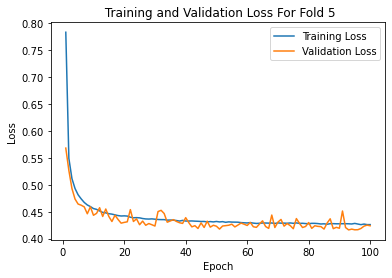

 50%|█████     | 5/10 [02:40<02:41, 32.24s/it]

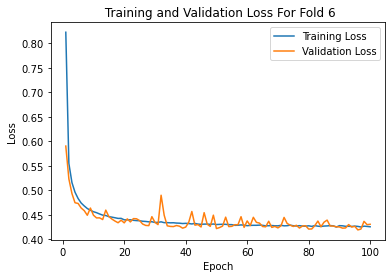

 60%|██████    | 6/10 [03:12<02:08, 32.15s/it]

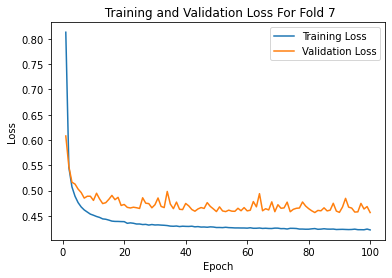

 70%|███████   | 7/10 [03:45<01:36, 32.14s/it]

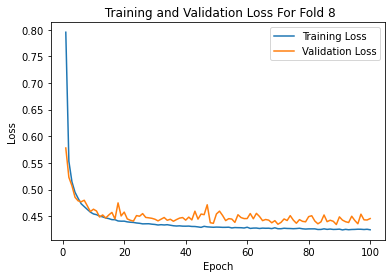

 80%|████████  | 8/10 [04:17<01:04, 32.27s/it]

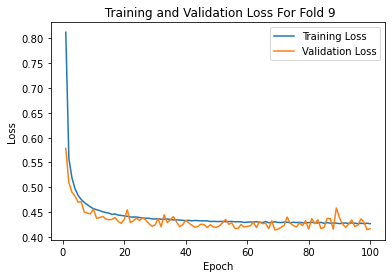

 90%|█████████ | 9/10 [04:49<00:32, 32.22s/it]

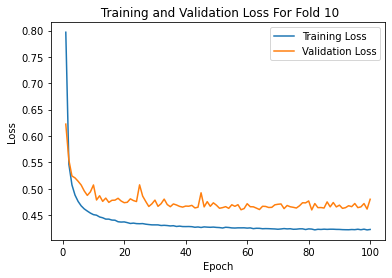

100%|██████████| 10/10 [05:21<00:00, 32.16s/it]


Average validation accuracy: 0.8535666666666668
PCS: 100
0.8386 all
(784, 100) k_pcs shape - all


  0%|          | 0/10 [00:00<?, ?it/s]

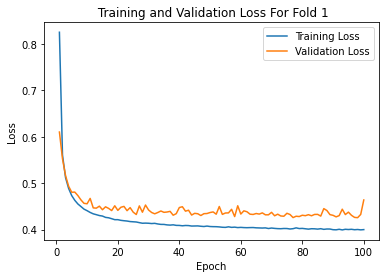

 10%|█         | 1/10 [00:48<07:15, 48.40s/it]

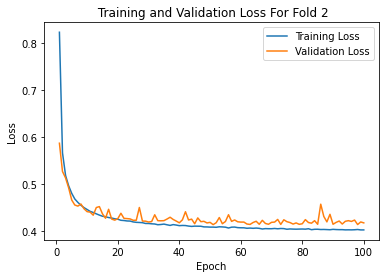

 20%|██        | 2/10 [01:37<06:28, 48.58s/it]

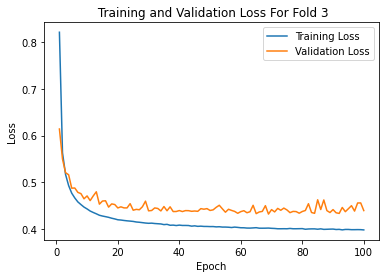

 30%|███       | 3/10 [02:26<05:40, 48.61s/it]

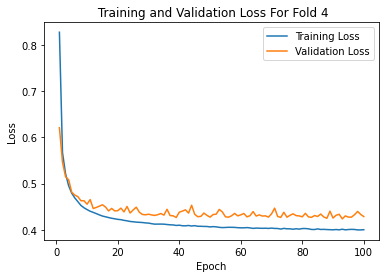

 40%|████      | 4/10 [03:15<04:52, 48.71s/it]

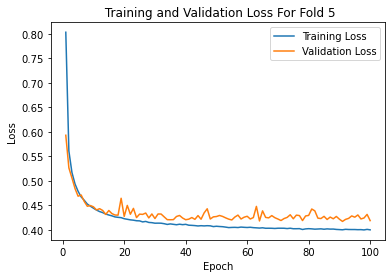

 50%|█████     | 5/10 [04:03<04:03, 48.66s/it]

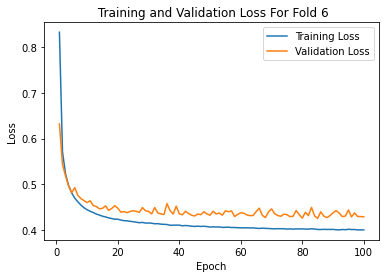

 60%|██████    | 6/10 [04:52<03:14, 48.63s/it]

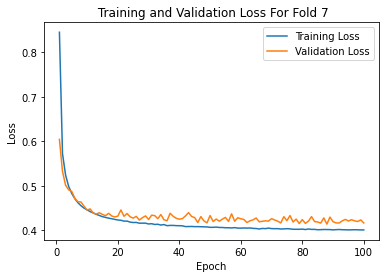

 70%|███████   | 7/10 [05:40<02:25, 48.65s/it]

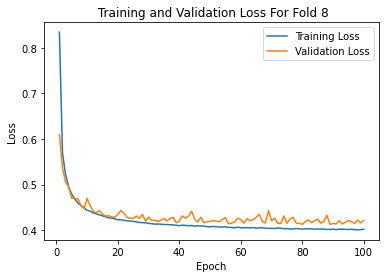

 80%|████████  | 8/10 [06:29<01:37, 48.58s/it]

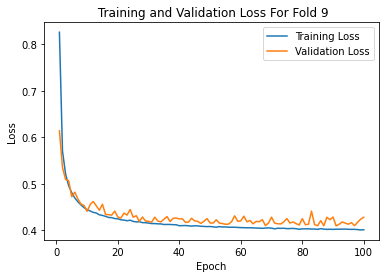

 90%|█████████ | 9/10 [07:17<00:48, 48.51s/it]

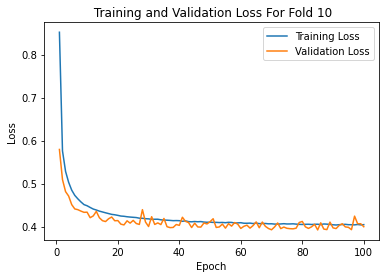

100%|██████████| 10/10 [08:06<00:00, 48.63s/it]


Average validation accuracy: 0.8605166666666666
PCS: 200
0.841 all
(784, 200) k_pcs shape - all


  0%|          | 0/10 [00:00<?, ?it/s]

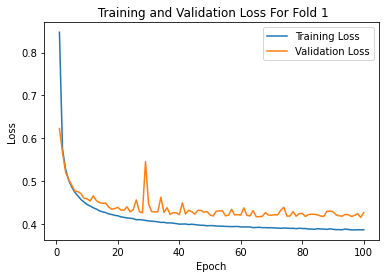

 10%|█         | 1/10 [01:14<11:07, 74.15s/it]

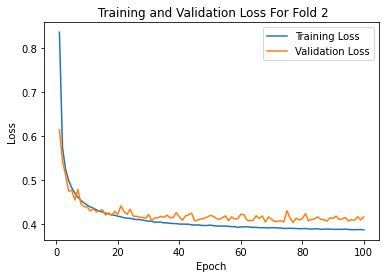

 20%|██        | 2/10 [02:26<09:49, 73.69s/it]

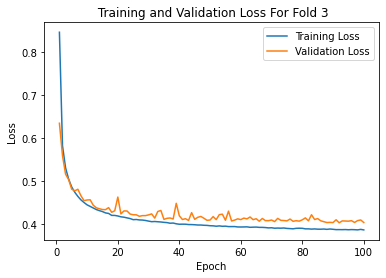

 30%|███       | 3/10 [03:39<08:34, 73.47s/it]

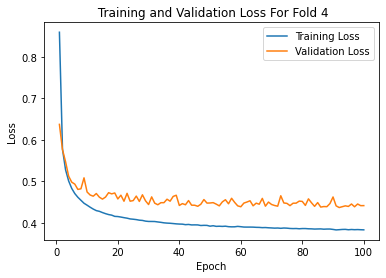

 40%|████      | 4/10 [04:52<07:19, 73.31s/it]

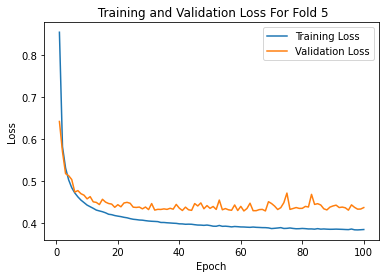

 50%|█████     | 5/10 [06:05<06:06, 73.20s/it]

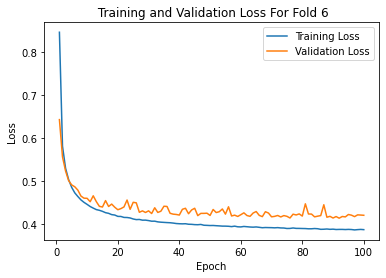

 60%|██████    | 6/10 [07:19<04:53, 73.26s/it]

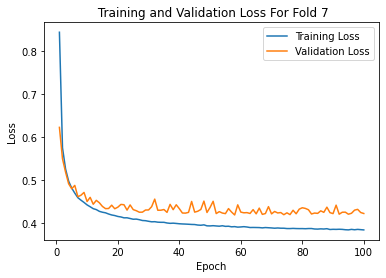

 70%|███████   | 7/10 [08:32<03:39, 73.25s/it]

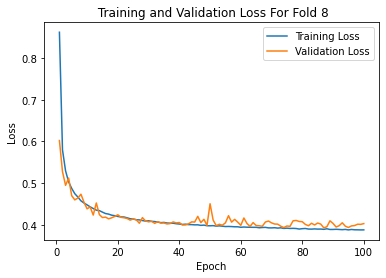

 80%|████████  | 8/10 [09:45<02:26, 73.30s/it]

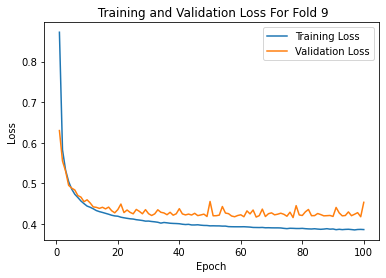

 90%|█████████ | 9/10 [10:58<01:13, 73.22s/it]

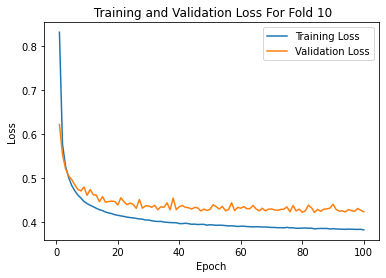

100%|██████████| 10/10 [12:12<00:00, 73.26s/it]


Average validation accuracy: 0.8659666666666667
PCS: 350
0.8434 all
(784, 350) k_pcs shape - all


  0%|          | 0/10 [00:00<?, ?it/s]

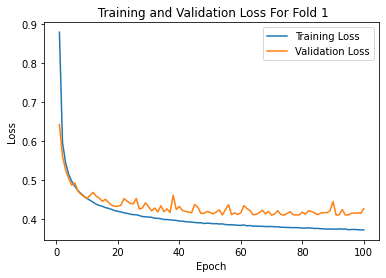

 10%|█         | 1/10 [02:23<21:35, 143.99s/it]

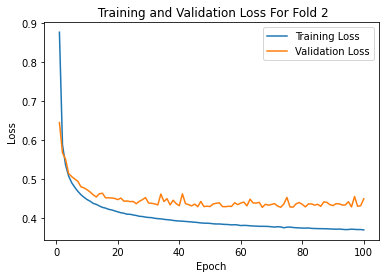

 20%|██        | 2/10 [04:48<19:12, 144.10s/it]

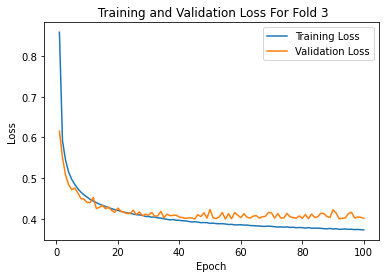

 30%|███       | 3/10 [07:12<16:48, 144.13s/it]

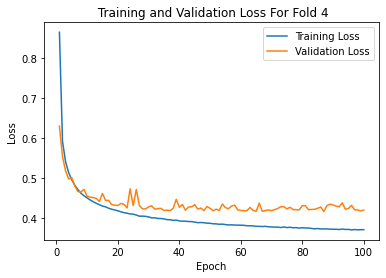

 40%|████      | 4/10 [09:37<14:25, 144.28s/it]

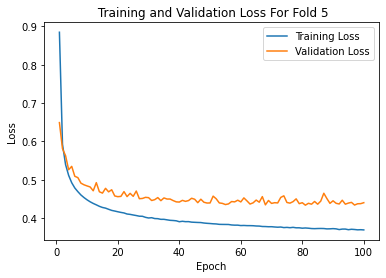

 50%|█████     | 5/10 [12:01<12:02, 144.43s/it]

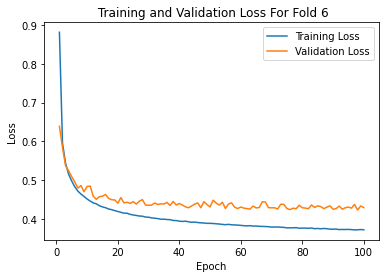

 60%|██████    | 6/10 [14:25<09:36, 144.20s/it]

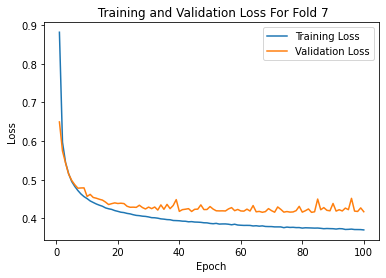

 70%|███████   | 7/10 [16:48<07:11, 143.95s/it]

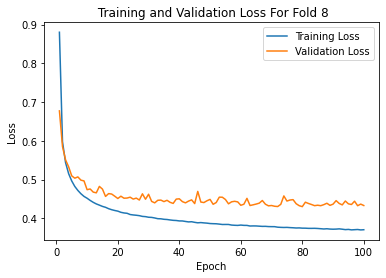

 80%|████████  | 8/10 [19:13<04:48, 144.06s/it]

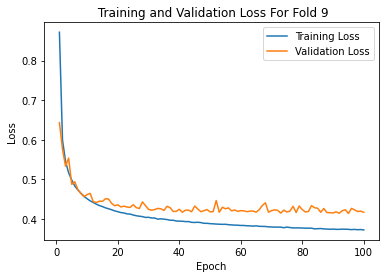

 90%|█████████ | 9/10 [21:37<02:24, 144.07s/it]

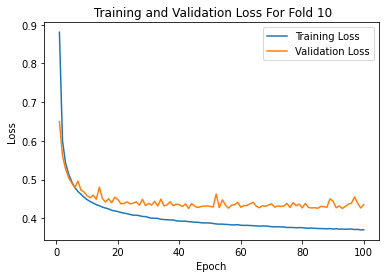

100%|██████████| 10/10 [24:02<00:00, 144.26s/it]


Average validation accuracy: 0.8666833333333335
PCS: 784
0.8447 all
(784, 784) k_pcs shape - all
DONE


In [3]:
pcs = []
if __name__ == "__main__":
    X_train, y_train = mnist_reader.load_mnist('fashion_mnist_dataset/data/fashion', kind='train')
    X_test, y_test   = mnist_reader.load_mnist('fashion_mnist_dataset/data/fashion', kind='t10k')
    
    # min-max normalize
    X_train = normalize(X_train)
    X_test  = normalize(X_test)
    
    j = [2, 10, 50, 100, 200, 350, 784]
    
    classes = [0, 9]
    for pc in j:
        model, k_pcs = logisticRegression(X_train, y_train, classes, 1, pc)
        acc = testModel(X_test, y_test, model, k_pcs, classes)
        print("PCS:", pc)
        print(acc, "0, 9")
        print(k_pcs.shape, "k_pcs shape - 09")
        
        
    classes = [2, 4]
    for pc in j:
        model, k_pcs = logisticRegression(X_train, y_train, classes, 2, pc)
        acc = testModel(X_test, y_test, model, k_pcs, classes)
        print("PCS:", pc)
        print(acc, "2, 4")
        print(k_pcs.shape, "k_pcs shape - 24")
        
    classes = list(range(10))
    for pc in j:
        model, k_pcs = softMaxRegression(X_train, y_train, classes, 3, pc)
        acc = testModel(X_test, y_test, model, k_pcs, classes)
        print("PCS:", pc)
        print(acc, "all")
        print(k_pcs.shape, "k_pcs shape - all")
    print("DONE")
    
#     classes = [0, 9] # classes we want for binary classification
#     model, k_pcs = logisticRegression(X_train, y_train, classes, 1)
#     acc = testModel(X_test, y_test, model, k_pcs, classes)
#     print(acc)
#     pcs.append(k_pcs)
    
#     classes = [2,4]
#     model, k_pcs = logisticRegression(X_train, y_train, classes, 2)
#     acc = testModel(X_test, y_test, model, k_pcs, classes)
#     print(acc)
#     pcs.append(k_pcs)
    
#     classes = list(range(10)) # classes we want for multiclass classification
#     model, k_pcs = softMaxRegression(X_train, y_train, classes, 3)
#     acc = testModel(X_test, y_test, model, k_pcs, classes)
#     print(acc)
#     pcs.append(k_pcs)
    